<a href="https://colab.research.google.com/github/mohripan/Job-Interview-Analysis/blob/main/RAVDESS_emotions_speech_audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download the Dataset

To download the dataset, I save my Kaggle API Key in my google drive so I don't need to upload it everytime.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!cp '/content/gdrive/MyDrive/KaggleAPI/kaggle.json' kaggle.json

In [3]:
!pip install -q kaggle

In [4]:
!mkdir -p ~/.kaggle

In [5]:
!cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

 96% 411M/429M [00:02<00:00, 153MB/s]
100% 429M/429M [00:02<00:00, 188MB/s]


In [8]:
!mkdir ravdess

In [9]:
!unzip -q /content/ravdess-emotional-speech-audio.zip -d ravdess

# The Library

There is nothing new we will add in the colab, but the problem here is, when I want to do data augmentation, librosa 0.10.2 (the original installed version of librosa in colab) has a little bit of a problem, so I need to install the 0.9.2. To look at the issue in detail, you can look at [here](https://github.com/CorentinJ/Real-Time-Voice-Cloning/issues/1166).

In [10]:
!pip uninstall -y librosa
!pip install librosa==0.9.2

Found existing installation: librosa 0.10.0.post2
Uninstalling librosa-0.10.0.post2:
  Successfully uninstalled librosa-0.10.0.post2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.3/214.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 47.3 MB/s eta 0:00:00


# EDA

The first thing I want to do is to listen one of the audio in my dataset and print out the labels. You can look at the detail of the dataset [here](https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio), but here is a big picture of the dataset.

The RAVDESS dataset is designed for emotion classification. The dataset includes 24 actors who vocalize different emotions across various statements. The file naming convention provided in the dataset description contains the information you need to identify the emotion associated with each audio file.

Here's a quick summary of the filename identifiers, focusing on the emotion part:
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised)

For example, in the filename "03-01-06-01-02-01-12.wav":
- The "06" in the filename represents the emotion, which is "fearful" in this case.

In [11]:
import os
import random
import pandas as pd
from IPython.display import Audio

In [12]:
# Define the path to the dataset folder
dataset_path = '/content/ravdess'

# Define a mapping for emotion identifiers to emotion labels
emotion_mapping = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

In [13]:
# Initialize an empty list to store the audio file paths
audio_files = []

# Iterate through the folders (actor_01 to actor_24)
for actor_folder in os.listdir(dataset_path):
    actor_path = os.path.join(dataset_path, actor_folder)
    
    # Check if the path is a directory (to avoid processing non-directory files)
    if os.path.isdir(actor_path):
        
        # Iterate through the audio files in the actor folder
        for audio_file in os.listdir(actor_path):
            audio_path = os.path.join(actor_path, audio_file)
            audio_files.append(audio_path)

In [14]:
# Select a random audio file
random_audio_file = random.choice(audio_files)

# Extract the emotion identifier from the filename (4th part of the filename)
emotion_id = os.path.basename(random_audio_file).split('-')[2]

# Map the emotion identifier to the corresponding emotion label
emotion_label = emotion_mapping[emotion_id]

# Print the emotion label and play the audio
print(f"Emotion: {emotion_label}")
Audio(filename=random_audio_file)

Emotion: angry


You can run the code above several times and match the emotion label and the sounds that you hear.

# Pre-processing The Dataset

After we saved the dataset, our next step is to preprocess the dataset. There are some process to preprocess the data before we feed it into the model. Those process are:
- Resampling
- Noise Reduction
- Trimming Silence
- Normalization

Our goal now is to preprocess the dataset and then save the preprocess into a different folder.

In [15]:
import os
import librosa
import soundfile as sf

Let's make a folder to save our preprocess dataset

In [16]:
!mkdir ravdess_preprocess

In [17]:
# Define the path to the dataset folder and the output folder for preprocessed audio files
dataset_path = '/content/ravdess'
output_path = '/content/ravdess_preprocess'

# Define the target sampling rate
target_sampling_rate = 22050

In [18]:
# Iterate through the folders (actor_01 to actor_24)
for actor_folder in os.listdir(dataset_path):
    actor_path = os.path.join(dataset_path, actor_folder)
    output_actor_path = os.path.join(output_path, actor_folder)
    
    # Create the output folder for the current actor if it doesn't exist
    os.makedirs(output_actor_path, exist_ok=True)

    # Check if the path is a directory (to avoid processing non-directory files)
    if os.path.isdir(actor_path):
        
        # Iterate through the audio files in the actor folder
        for audio_file in os.listdir(actor_path):
            
            if audio_file.endswith('.wav'):
                audio_path = os.path.join(actor_path, audio_file)
                output_audio_path = os.path.join(output_actor_path, audio_file)

                # Load the audio file using librosa
                audio, sampling_rate = librosa.load(audio_path, sr=None)

                # Resample the audio to the target sampling rate
                if sampling_rate != target_sampling_rate:
                    audio = librosa.resample(audio, orig_sr=sampling_rate, target_sr=target_sampling_rate)

                # Trim leading and trailing silence
                audio, _ = librosa.effects.trim(audio, top_db=30)

                # Normalize the amplitude
                audio = librosa.util.normalize(audio)

                # Save the preprocessed audio file
                sf.write(output_audio_path, audio, target_sampling_rate, format='wav')

Now, let us hear the preprocessing data

In [19]:
# Define the path to the dataset folder
dataset_path = '/content/ravdess_preprocess'

# Define a mapping for emotion identifiers to emotion labels
emotion_mapping = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

In [20]:
# Initialize an empty list to store the audio file paths
audio_files = []

# Iterate through the folders (actor_01 to actor_24)
for actor_folder in os.listdir(dataset_path):
    actor_path = os.path.join(dataset_path, actor_folder)
    
    # Check if the path is a directory (to avoid processing non-directory files)
    if os.path.isdir(actor_path):
        
        # Iterate through the audio files in the actor folder
        for audio_file in os.listdir(actor_path):
            audio_path = os.path.join(actor_path, audio_file)
            audio_files.append(audio_path)

In [21]:
# Select a random audio file
random_audio_file = random.choice(audio_files)

# Extract the emotion identifier from the filename (4th part of the filename)
emotion_id = os.path.basename(random_audio_file).split('-')[2]

# Map the emotion identifier to the corresponding emotion label
emotion_label = emotion_mapping[emotion_id]

# Print the emotion label and play the audio
print(f"Emotion: {emotion_label}")
Audio(filename=random_audio_file)

Emotion: angry


# Save the Dataset Into .csv File

After we did preprocessing dataset, we want to save the data to .csv file. You don't have to do this, but it will make the formatting easier.

In [22]:
# Define the path to the dataset folder
dataset_path = '/content/ravdess_preprocess'

# Define a mapping for emotion identifiers to emotion labels
emotion_mapping = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

In [23]:
# Initialize an empty list to store the data
data = []

# Iterate through the folders (actor_01 to actor_24)
for actor_folder in os.listdir(dataset_path):
    actor_path = os.path.join(dataset_path, actor_folder)
    
    # Check if the path is a directory (to avoid processing non-directory files)
    if os.path.isdir(actor_path):
        
        # Iterate through the audio files in the actor folder
        for audio_file in os.listdir(actor_path):
            
            # Check if the file is an audio file (has a .wav extension)
            if audio_file.endswith('.wav'):
                audio_path = os.path.join(actor_path, audio_file)

                # Extract the emotion identifier from the filename (4th part of the filename)
                filename_parts = audio_file.split('-')
                if len(filename_parts) > 2:
                    emotion_id = filename_parts[2]

                    # Map the emotion identifier to the corresponding emotion label
                    emotion_label = emotion_mapping.get(emotion_id)

                    if emotion_label is not None:
                        # Append the audio path and emotion label to the data list
                        data.append([audio_path, emotion_label])

# Create a pandas DataFrame from the data list
df = pd.DataFrame(data, columns=['audio_path', 'emotion'])

# Display the first few rows of the DataFrame
print(df.head())

# Save the DataFrame to a CSV file
df.to_csv('RAVDESS_emotion_labels.csv', index=False)

                                          audio_path    emotion
0  /content/ravdess_preprocess/Actor_11/03-01-04-...        sad
1  /content/ravdess_preprocess/Actor_11/03-01-08-...  surprised
2  /content/ravdess_preprocess/Actor_11/03-01-04-...        sad
3  /content/ravdess_preprocess/Actor_11/03-01-05-...      angry
4  /content/ravdess_preprocess/Actor_11/03-01-02-...       calm


# Feature Extraction
Feature extraction is an essential step in machine learning, especially for tasks involving complex data like audio. Raw data often contains a lot of irrelevant or redundant information that can negatively impact the performance of machine learning models. By extracting meaningful features from the raw data, we can represent the data more compactly and efficiently, which helps the model learn better and make more accurate predictions.

For speech and audio analysis, Mel-frequency cepstral coefficients (MFCCs) are a widely used set of features. MFCCs represent the spectral envelope of the audio signal, which captures the characteristics of the speaker's voice and the spoken content. By using MFCCs as input features, we can simplify the audio data while retaining the essential information required for the machine learning model to recognize patterns related to emotions in the audio signal.

In [24]:
import pandas as pd
import numpy as np
import librosa

In [25]:
# Load the DataFrame from the preprocessed .csv file
df = pd.read_csv('RAVDESS_emotion_labels.csv')

# Define the parameters for MFCC feature extraction
n_mfcc = 13
n_fft = 2048
hop_length = 512

In [26]:
def augment_audio(audio, sr, time_stretch_range=(-0.1, 0.1), pitch_shift_range=(-2, 2), noise_level_range=(0.001, 0.01)):
    # Time stretching
    rate = np.random.uniform(1 + time_stretch_range[0], 1 + time_stretch_range[1])
    audio = librosa.effects.time_stretch(audio, rate)

    # Pitch shifting
    n_steps = np.random.randint(pitch_shift_range[0], pitch_shift_range[1])
    audio = librosa.effects.pitch_shift(audio, sr, n_steps=n_steps)

    # Adding noise
    noise_level = np.random.uniform(noise_level_range[0], noise_level_range[1])
    noise = np.random.normal(0, noise_level, audio.shape)
    audio = audio + noise

    return audio

In [27]:
# Initialize an empty list to store the features
features = []

# Iterate through the DataFrame rows
for index, row in df.iterrows():
    audio_path = row['audio_path']
    emotion = row['emotion']

    # Load the preprocessed audio file
    audio, _ = librosa.load(audio_path, sr=None)

    # Apply data augmentation
    augmented_audio = augment_audio(audio, sr=_)

    # Extract the MFCC features
    mfcc = librosa.feature.mfcc(y=augmented_audio, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

    # Calculate the mean MFCC features
    mean_mfcc = np.mean(mfcc, axis=1)
    mean_mfcc = np.pad(mean_mfcc, (0, 16 - n_mfcc), 'constant')

    # Append the mean MFCC features and the emotion label to the features list
    features.append(np.append(mean_mfcc, emotion))

<ipython-input-26-baaad95e37ae>:4: FutureWarning: Pass rate=0.9800694451794748 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio = librosa.effects.time_stretch(audio, rate)
<ipython-input-26-baaad95e37ae>:8: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio = librosa.effects.pitch_shift(audio, sr, n_steps=n_steps)
<ipython-input-26-baaad95e37ae>:4: FutureWarning: Pass rate=1.06598018012403 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio = librosa.effects.time_stretch(audio, rate)
<ipython-input-26-baaad95e37ae>:4: FutureWarning: Pass rate=1.0561891846200666 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio = librosa.effects.time_stretch(audio, rate)
<ipython-input-26-baaad95e37ae>:4: FutureWarning: Pass rate=0.9818251353665469 as keyword a

In [28]:
# Create a pandas DataFrame from the features list
feature_columns = [f'mfcc_{i + 1}' for i in range(16)] + ['emotion']
features_df = pd.DataFrame(features, columns=feature_columns)

# Display the first few rows of the features DataFrame
print(features_df.head())

# Save the features DataFrame to a CSV file
features_df.to_csv('RAVDESS_MFCC_features.csv', index=False)

                mfcc_1             mfcc_2              mfcc_3  \
0   -233.9595001467316  88.66336396151888   3.734975847066396   
1   -172.3660939111449  59.16409448756651   6.155394659005598   
2  -229.46549288788788  76.49871930962352   34.73313718544514   
3  -157.39856848552847  46.24048385791513  1.2966838322173853   
4  -203.91263891793398  41.85254627372593  16.668295283074634   

                mfcc_4                mfcc_5               mfcc_6  \
0    7.915408752647878    -8.831046392980287  -1.7607710288918328   
1    7.890295454174239    -8.464575591375333   0.7030819146304531   
2   30.636378477232977  -0.15845177516062336   5.9179458239733265   
3  -2.0148004114021836   -17.776199638375953  -13.828222244436445   
4    20.00071882879187     8.308734865229331    7.673373685696063   

                mfcc_7               mfcc_8               mfcc_9  \
0  -11.113374842852863  -12.794528140913433  -17.525508526390993   
1  -14.646956221181306   -7.485045708380144  -18.233857477

# Data Preparation

Finally, we want to split the dataset into training and test sets. We also want to encode our data. In this case, I use PyTorch to prepare my data. In here, I used StandardScaler from sklearn, and I want to save my scaler so I can just transform it into different dataset.

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import pickle
from torch.utils.data import DataLoader, Dataset

In [30]:
# Load the features DataFrame from the .csv file
features_df = pd.read_csv('RAVDESS_MFCC_features.csv')

# Define the emotion mapping
emotion_mapping = {
    'neutral': 1,
    'calm': 2,
    'happy': 3,
    'sad': 4,
    'angry': 5,
    'fearful': 6,
    'disgust': 7,
    'surprised': 8
}

# Apply the emotion mapping to the 'emotion' column
features_df['emotion'] = features_df['emotion'].map(emotion_mapping)

In [31]:
# Separate features and labels
X = features_df.drop('emotion', axis=1)
y = features_df['emotion']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize the features
scaler = StandardScaler() # We might want to save it
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [48]:
# Define a custom PyTorch Dataset class for the emotion recognition data
class EmotionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        features = torch.tensor(self.X[idx], dtype=torch.float32)
        label = torch.tensor(self.y.iloc[idx] - 1, dtype=torch.long)  # Subtract 1 to make the labels 0-indexed
        return features, label

In [49]:
# Instantiate the custom Dataset and DataLoader objects for the training and testing sets
train_dataset = EmotionDataset(X_train_normalized, y_train)
test_dataset = EmotionDataset(X_test_normalized, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Save the scaler

In [50]:
# Save the scaler to a file
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Let's Train a Machine Learning Model
Finally, after we have preprared the dataset, we will train the model. For this particular case, I will use Transformer architecture. I also try to make the model smaller to avoid overkill, and might update it later.

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import os
from tqdm import tqdm

from sklearn.model_selection import KFold
from itertools import product

In [52]:
# Define the Transformer model
class EmotionClassifier(nn.Module):
    def __init__(self, input_dim, nhead, num_layers, dim_feedforward, num_classes):
        super().__init__()
        self.transformer = nn.Transformer(input_dim, nhead, num_layers, dim_feedforward)
        self.fc1 = nn.Linear(input_dim, dim_feedforward)
        self.fc2 = nn.Linear(dim_feedforward, dim_feedforward // 2)
        self.fc3 = nn.Linear(dim_feedforward // 2, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add an extra dimension for the sequence length
        x = x.repeat(1, 2, 1)  # Repeat the input along the sequence length dimension to have length 32
        x = x.transpose(0, 1)
        x = self.transformer.encoder(x)
        x = x.transpose(0, 1)
        x = F.relu(self.fc1(x[:, 0, :]))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [106]:
# Instantiate the model
input_dim = X_train.shape[1]
nhead = 4
num_layers = 3
dim_feedforward = 128
num_classes = len(y.unique())
model = EmotionClassifier(input_dim, nhead, num_layers, dim_feedforward, num_classes)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

EmotionClassifier(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
          )
          (linear1): Linear(in_features=16, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=16, bias=True)
          (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-127): 128 x TransformerDecoderLayer(
          (self_attn): MultiheadAttentio

## Hyperparameter Tuning

In [107]:
# Define hyperparameter grid
lr_grid = [0.001, 0.0005]
num_layers_grid = [2, 3]
dim_feedforward_grid = [64, 128]

In [108]:
# Perform grid search
param_grid = list(product(lr_grid, num_layers_grid, dim_feedforward_grid))

In [109]:
# Define K-fold cross-validation
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

In [110]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.00001)

In [111]:
# Train the model
num_epochs = 500
save_dir = "models"
os.makedirs(save_dir, exist_ok=True)

In [112]:
def train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs, save_dir):
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")
        for batch in pbar:
            X_batch, y_batch = batch
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            pbar.set_postfix(train_loss=total_loss / len(train_loader))

        # Calculate validation loss
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                X_batch, y_batch = batch
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item()

        val_loss /= len(test_loader)
        print(f'Validation Loss: {val_loss}')

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pth"))
            print(f'Saving best model with validation loss: {best_val_loss}')

train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs, save_dir)

Epoch 1/500: 100%|██████████| 36/36 [00:00<00:00, 44.93it/s, train_loss=2.08]


Validation Loss: 2.087003310521444
Saving best model with validation loss: 2.087003310521444


Epoch 2/500: 100%|██████████| 36/36 [00:00<00:00, 45.60it/s, train_loss=2.08]


Validation Loss: 2.0820404158698187
Saving best model with validation loss: 2.0820404158698187


Epoch 3/500: 100%|██████████| 36/36 [00:00<00:00, 51.81it/s, train_loss=2.07]


Validation Loss: 2.076860851711697
Saving best model with validation loss: 2.076860851711697


Epoch 4/500: 100%|██████████| 36/36 [00:00<00:00, 45.56it/s, train_loss=2.07]


Validation Loss: 2.071689976586236
Saving best model with validation loss: 2.071689976586236


Epoch 5/500: 100%|██████████| 36/36 [00:00<00:00, 57.47it/s, train_loss=2.06]


Validation Loss: 2.066412740283542
Saving best model with validation loss: 2.066412740283542


Epoch 6/500: 100%|██████████| 36/36 [00:00<00:00, 76.88it/s, train_loss=2.06]


Validation Loss: 2.061629851659139
Saving best model with validation loss: 2.061629851659139


Epoch 7/500: 100%|██████████| 36/36 [00:00<00:00, 75.53it/s, train_loss=2.05]


Validation Loss: 2.0565285947587757
Saving best model with validation loss: 2.0565285947587757


Epoch 8/500: 100%|██████████| 36/36 [00:00<00:00, 75.08it/s, train_loss=2.05]


Validation Loss: 2.0517862372928195
Saving best model with validation loss: 2.0517862372928195


Epoch 9/500: 100%|██████████| 36/36 [00:00<00:00, 74.28it/s, train_loss=2.05]


Validation Loss: 2.0468604034847684
Saving best model with validation loss: 2.0468604034847684


Epoch 10/500: 100%|██████████| 36/36 [00:00<00:00, 74.55it/s, train_loss=2.04]


Validation Loss: 2.042185809877184
Saving best model with validation loss: 2.042185809877184


Epoch 11/500: 100%|██████████| 36/36 [00:00<00:00, 75.42it/s, train_loss=2.04]


Validation Loss: 2.0373895433213978
Saving best model with validation loss: 2.0373895433213978


Epoch 12/500: 100%|██████████| 36/36 [00:00<00:00, 74.84it/s, train_loss=2.04]


Validation Loss: 2.033035331302219
Saving best model with validation loss: 2.033035331302219


Epoch 13/500: 100%|██████████| 36/36 [00:00<00:00, 74.64it/s, train_loss=2.03]


Validation Loss: 2.0286910268995495
Saving best model with validation loss: 2.0286910268995495


Epoch 14/500: 100%|██████████| 36/36 [00:00<00:00, 74.57it/s, train_loss=2.03]


Validation Loss: 2.0239649746153088
Saving best model with validation loss: 2.0239649746153088


Epoch 15/500: 100%|██████████| 36/36 [00:00<00:00, 75.96it/s, train_loss=2.03]


Validation Loss: 2.0195360051261053
Saving best model with validation loss: 2.0195360051261053


Epoch 16/500: 100%|██████████| 36/36 [00:00<00:00, 72.02it/s, train_loss=2.02]


Validation Loss: 2.0153089894188776
Saving best model with validation loss: 2.0153089894188776


Epoch 17/500: 100%|██████████| 36/36 [00:00<00:00, 74.17it/s, train_loss=2.02]


Validation Loss: 2.0108105076683893
Saving best model with validation loss: 2.0108105076683893


Epoch 18/500: 100%|██████████| 36/36 [00:00<00:00, 64.20it/s, train_loss=2.01]


Validation Loss: 2.0065469476911755
Saving best model with validation loss: 2.0065469476911755


Epoch 19/500: 100%|██████████| 36/36 [00:00<00:00, 59.76it/s, train_loss=2.01]


Validation Loss: 2.002354714605543
Saving best model with validation loss: 2.002354714605543


Epoch 20/500: 100%|██████████| 36/36 [00:00<00:00, 59.11it/s, train_loss=2.01]


Validation Loss: 1.998083472251892
Saving best model with validation loss: 1.998083472251892


Epoch 21/500: 100%|██████████| 36/36 [00:00<00:00, 58.58it/s, train_loss=2]


Validation Loss: 1.9941346380445693
Saving best model with validation loss: 1.9941346380445693


Epoch 22/500: 100%|██████████| 36/36 [00:00<00:00, 66.59it/s, train_loss=2]


Validation Loss: 1.990300973256429
Saving best model with validation loss: 1.990300973256429


Epoch 23/500: 100%|██████████| 36/36 [00:00<00:00, 74.07it/s, train_loss=2]


Validation Loss: 1.9862002399232652
Saving best model with validation loss: 1.9862002399232652


Epoch 24/500: 100%|██████████| 36/36 [00:00<00:00, 75.45it/s, train_loss=1.99]


Validation Loss: 1.9822932084401448
Saving best model with validation loss: 1.9822932084401448


Epoch 25/500: 100%|██████████| 36/36 [00:00<00:00, 74.20it/s, train_loss=1.99]


Validation Loss: 1.978466510772705
Saving best model with validation loss: 1.978466510772705


Epoch 26/500: 100%|██████████| 36/36 [00:00<00:00, 71.62it/s, train_loss=1.99]


Validation Loss: 1.974581691953871
Saving best model with validation loss: 1.974581691953871


Epoch 27/500: 100%|██████████| 36/36 [00:00<00:00, 74.03it/s, train_loss=1.98]


Validation Loss: 1.970289707183838
Saving best model with validation loss: 1.970289707183838


Epoch 28/500: 100%|██████████| 36/36 [00:00<00:00, 74.66it/s, train_loss=1.98]


Validation Loss: 1.9667379061381023
Saving best model with validation loss: 1.9667379061381023


Epoch 29/500: 100%|██████████| 36/36 [00:00<00:00, 73.93it/s, train_loss=1.98]


Validation Loss: 1.9625899526807997
Saving best model with validation loss: 1.9625899526807997


Epoch 30/500: 100%|██████████| 36/36 [00:00<00:00, 73.11it/s, train_loss=1.97]


Validation Loss: 1.958848966492547
Saving best model with validation loss: 1.958848966492547


Epoch 31/500: 100%|██████████| 36/36 [00:00<00:00, 71.07it/s, train_loss=1.97]


Validation Loss: 1.9550017515818279
Saving best model with validation loss: 1.9550017515818279


Epoch 32/500: 100%|██████████| 36/36 [00:00<00:00, 74.62it/s, train_loss=1.97]


Validation Loss: 1.9512422482172649
Saving best model with validation loss: 1.9512422482172649


Epoch 33/500: 100%|██████████| 36/36 [00:00<00:00, 75.41it/s, train_loss=1.96]


Validation Loss: 1.947912123468187
Saving best model with validation loss: 1.947912123468187


Epoch 34/500: 100%|██████████| 36/36 [00:00<00:00, 73.21it/s, train_loss=1.96]


Validation Loss: 1.9441963699128892
Saving best model with validation loss: 1.9441963699128892


Epoch 35/500: 100%|██████████| 36/36 [00:00<00:00, 58.38it/s, train_loss=1.96]


Validation Loss: 1.941044118669298
Saving best model with validation loss: 1.941044118669298


Epoch 36/500: 100%|██████████| 36/36 [00:00<00:00, 56.76it/s, train_loss=1.95]


Validation Loss: 1.9370930327309503
Saving best model with validation loss: 1.9370930327309503


Epoch 37/500: 100%|██████████| 36/36 [00:00<00:00, 58.08it/s, train_loss=1.95]


Validation Loss: 1.9332860443327162
Saving best model with validation loss: 1.9332860443327162


Epoch 38/500: 100%|██████████| 36/36 [00:00<00:00, 49.54it/s, train_loss=1.94]


Validation Loss: 1.929611908064948
Saving best model with validation loss: 1.929611908064948


Epoch 39/500: 100%|██████████| 36/36 [00:00<00:00, 73.14it/s, train_loss=1.94]


Validation Loss: 1.926387654410468
Saving best model with validation loss: 1.926387654410468


Epoch 40/500: 100%|██████████| 36/36 [00:00<00:00, 73.95it/s, train_loss=1.93]


Validation Loss: 1.922420899073283
Saving best model with validation loss: 1.922420899073283


Epoch 41/500: 100%|██████████| 36/36 [00:00<00:00, 70.89it/s, train_loss=1.94]


Validation Loss: 1.9191147353914049
Saving best model with validation loss: 1.9191147353914049


Epoch 42/500: 100%|██████████| 36/36 [00:00<00:00, 72.69it/s, train_loss=1.93]


Validation Loss: 1.9157953394783869
Saving best model with validation loss: 1.9157953394783869


Epoch 43/500: 100%|██████████| 36/36 [00:00<00:00, 70.96it/s, train_loss=1.93]


Validation Loss: 1.9123225609461467
Saving best model with validation loss: 1.9123225609461467


Epoch 44/500: 100%|██████████| 36/36 [00:00<00:00, 73.99it/s, train_loss=1.92]


Validation Loss: 1.9088530672921076
Saving best model with validation loss: 1.9088530672921076


Epoch 45/500: 100%|██████████| 36/36 [00:00<00:00, 70.06it/s, train_loss=1.92]


Validation Loss: 1.9059873951805963
Saving best model with validation loss: 1.9059873951805963


Epoch 46/500: 100%|██████████| 36/36 [00:00<00:00, 73.86it/s, train_loss=1.92]


Validation Loss: 1.9026327000723944
Saving best model with validation loss: 1.9026327000723944


Epoch 47/500: 100%|██████████| 36/36 [00:00<00:00, 74.55it/s, train_loss=1.92]


Validation Loss: 1.9000140693452623
Saving best model with validation loss: 1.9000140693452623


Epoch 48/500: 100%|██████████| 36/36 [00:00<00:00, 73.11it/s, train_loss=1.91]


Validation Loss: 1.8960229555765789
Saving best model with validation loss: 1.8960229555765789


Epoch 49/500: 100%|██████████| 36/36 [00:00<00:00, 73.53it/s, train_loss=1.9]


Validation Loss: 1.892349984910753
Saving best model with validation loss: 1.892349984910753


Epoch 50/500: 100%|██████████| 36/36 [00:00<00:00, 72.67it/s, train_loss=1.91]


Validation Loss: 1.889605164527893
Saving best model with validation loss: 1.889605164527893


Epoch 51/500: 100%|██████████| 36/36 [00:00<00:00, 56.74it/s, train_loss=1.9]


Validation Loss: 1.886104530758328
Saving best model with validation loss: 1.886104530758328


Epoch 52/500: 100%|██████████| 36/36 [00:00<00:00, 58.71it/s, train_loss=1.9]


Validation Loss: 1.8834352758195665
Saving best model with validation loss: 1.8834352758195665


Epoch 53/500: 100%|██████████| 36/36 [00:00<00:00, 60.82it/s, train_loss=1.89]


Validation Loss: 1.8800091081195407
Saving best model with validation loss: 1.8800091081195407


Epoch 54/500: 100%|██████████| 36/36 [00:00<00:00, 55.61it/s, train_loss=1.89]


Validation Loss: 1.8778977129194472
Saving best model with validation loss: 1.8778977129194472


Epoch 55/500: 100%|██████████| 36/36 [00:00<00:00, 72.03it/s, train_loss=1.89]


Validation Loss: 1.8749029106563992
Saving best model with validation loss: 1.8749029106563992


Epoch 56/500: 100%|██████████| 36/36 [00:00<00:00, 73.22it/s, train_loss=1.89]


Validation Loss: 1.8715918329026964
Saving best model with validation loss: 1.8715918329026964


Epoch 57/500: 100%|██████████| 36/36 [00:00<00:00, 71.57it/s, train_loss=1.88]


Validation Loss: 1.8689956135219998
Saving best model with validation loss: 1.8689956135219998


Epoch 58/500: 100%|██████████| 36/36 [00:00<00:00, 69.70it/s, train_loss=1.88]


Validation Loss: 1.8666538662380643
Saving best model with validation loss: 1.8666538662380643


Epoch 59/500: 100%|██████████| 36/36 [00:00<00:00, 73.16it/s, train_loss=1.88]


Validation Loss: 1.863318469789293
Saving best model with validation loss: 1.863318469789293


Epoch 60/500: 100%|██████████| 36/36 [00:00<00:00, 71.88it/s, train_loss=1.87]


Validation Loss: 1.8604609304004245
Saving best model with validation loss: 1.8604609304004245


Epoch 61/500: 100%|██████████| 36/36 [00:00<00:00, 71.14it/s, train_loss=1.87]


Validation Loss: 1.8571106062995062
Saving best model with validation loss: 1.8571106062995062


Epoch 62/500: 100%|██████████| 36/36 [00:00<00:00, 71.76it/s, train_loss=1.87]


Validation Loss: 1.8537182675467596
Saving best model with validation loss: 1.8537182675467596


Epoch 63/500: 100%|██████████| 36/36 [00:00<00:00, 71.26it/s, train_loss=1.86]


Validation Loss: 1.8519240485297308
Saving best model with validation loss: 1.8519240485297308


Epoch 64/500: 100%|██████████| 36/36 [00:00<00:00, 57.50it/s, train_loss=1.86]


Validation Loss: 1.8495438363817003
Saving best model with validation loss: 1.8495438363817003


Epoch 65/500: 100%|██████████| 36/36 [00:00<00:00, 73.18it/s, train_loss=1.86]


Validation Loss: 1.846377068095737
Saving best model with validation loss: 1.846377068095737


Epoch 66/500: 100%|██████████| 36/36 [00:00<00:00, 69.31it/s, train_loss=1.85]


Validation Loss: 1.84353682729933
Saving best model with validation loss: 1.84353682729933


Epoch 67/500: 100%|██████████| 36/36 [00:00<00:00, 56.14it/s, train_loss=1.85]


Validation Loss: 1.8420638508266873
Saving best model with validation loss: 1.8420638508266873


Epoch 68/500: 100%|██████████| 36/36 [00:00<00:00, 57.28it/s, train_loss=1.85]


Validation Loss: 1.838881942960951
Saving best model with validation loss: 1.838881942960951


Epoch 69/500: 100%|██████████| 36/36 [00:00<00:00, 54.36it/s, train_loss=1.85]


Validation Loss: 1.8359720044665866
Saving best model with validation loss: 1.8359720044665866


Epoch 70/500: 100%|██████████| 36/36 [00:00<00:00, 58.94it/s, train_loss=1.85]


Validation Loss: 1.8338145812352498
Saving best model with validation loss: 1.8338145812352498


Epoch 71/500: 100%|██████████| 36/36 [00:00<00:00, 72.69it/s, train_loss=1.84]


Validation Loss: 1.831099033355713
Saving best model with validation loss: 1.831099033355713


Epoch 72/500: 100%|██████████| 36/36 [00:00<00:00, 69.35it/s, train_loss=1.84]


Validation Loss: 1.8282617330551147
Saving best model with validation loss: 1.8282617330551147


Epoch 73/500: 100%|██████████| 36/36 [00:00<00:00, 69.66it/s, train_loss=1.83]


Validation Loss: 1.8263116280237834
Saving best model with validation loss: 1.8263116280237834


Epoch 74/500: 100%|██████████| 36/36 [00:00<00:00, 72.98it/s, train_loss=1.83]


Validation Loss: 1.8241659667756822
Saving best model with validation loss: 1.8241659667756822


Epoch 75/500: 100%|██████████| 36/36 [00:00<00:00, 68.03it/s, train_loss=1.83]


Validation Loss: 1.821575853559706
Saving best model with validation loss: 1.821575853559706


Epoch 76/500: 100%|██████████| 36/36 [00:00<00:00, 70.01it/s, train_loss=1.83]


Validation Loss: 1.818597846561008
Saving best model with validation loss: 1.818597846561008


Epoch 77/500: 100%|██████████| 36/36 [00:00<00:00, 72.39it/s, train_loss=1.82]


Validation Loss: 1.81617185804579
Saving best model with validation loss: 1.81617185804579


Epoch 78/500: 100%|██████████| 36/36 [00:00<00:00, 72.17it/s, train_loss=1.82]


Validation Loss: 1.8135969241460164
Saving best model with validation loss: 1.8135969241460164


Epoch 79/500: 100%|██████████| 36/36 [00:00<00:00, 70.89it/s, train_loss=1.82]


Validation Loss: 1.8114311297734578
Saving best model with validation loss: 1.8114311297734578


Epoch 80/500: 100%|██████████| 36/36 [00:00<00:00, 73.38it/s, train_loss=1.82]


Validation Loss: 1.808838235007392
Saving best model with validation loss: 1.808838235007392


Epoch 81/500: 100%|██████████| 36/36 [00:00<00:00, 70.77it/s, train_loss=1.81]


Validation Loss: 1.8060054646597967
Saving best model with validation loss: 1.8060054646597967


Epoch 82/500: 100%|██████████| 36/36 [00:00<00:00, 63.86it/s, train_loss=1.81]


Validation Loss: 1.8043276601367526
Saving best model with validation loss: 1.8043276601367526


Epoch 83/500: 100%|██████████| 36/36 [00:00<00:00, 54.13it/s, train_loss=1.8]


Validation Loss: 1.8019860188166301
Saving best model with validation loss: 1.8019860188166301


Epoch 84/500: 100%|██████████| 36/36 [00:00<00:00, 55.82it/s, train_loss=1.81]


Validation Loss: 1.7990799744923909
Saving best model with validation loss: 1.7990799744923909


Epoch 85/500: 100%|██████████| 36/36 [00:00<00:00, 53.16it/s, train_loss=1.8]


Validation Loss: 1.7958568467034235
Saving best model with validation loss: 1.7958568467034235


Epoch 86/500: 100%|██████████| 36/36 [00:00<00:00, 71.94it/s, train_loss=1.8]


Validation Loss: 1.79475908809238
Saving best model with validation loss: 1.79475908809238


Epoch 87/500: 100%|██████████| 36/36 [00:00<00:00, 70.60it/s, train_loss=1.8]


Validation Loss: 1.792657944891188
Saving best model with validation loss: 1.792657944891188


Epoch 88/500: 100%|██████████| 36/36 [00:00<00:00, 70.96it/s, train_loss=1.8]


Validation Loss: 1.7917948696348402
Saving best model with validation loss: 1.7917948696348402


Epoch 89/500: 100%|██████████| 36/36 [00:00<00:00, 68.17it/s, train_loss=1.79]


Validation Loss: 1.789197153515286
Saving best model with validation loss: 1.789197153515286


Epoch 90/500: 100%|██████████| 36/36 [00:00<00:00, 70.26it/s, train_loss=1.79]


Validation Loss: 1.78578609890408
Saving best model with validation loss: 1.78578609890408


Epoch 91/500: 100%|██████████| 36/36 [00:00<00:00, 67.61it/s, train_loss=1.79]


Validation Loss: 1.783442457516988
Saving best model with validation loss: 1.783442457516988


Epoch 92/500: 100%|██████████| 36/36 [00:00<00:00, 39.77it/s, train_loss=1.78]


Validation Loss: 1.7809105184343126
Saving best model with validation loss: 1.7809105184343126


Epoch 93/500: 100%|██████████| 36/36 [00:00<00:00, 72.67it/s, train_loss=1.78]


Validation Loss: 1.778980811436971
Saving best model with validation loss: 1.778980811436971


Epoch 94/500: 100%|██████████| 36/36 [00:00<00:00, 72.17it/s, train_loss=1.78]


Validation Loss: 1.7764458656311035
Saving best model with validation loss: 1.7764458656311035


Epoch 95/500: 100%|██████████| 36/36 [00:00<00:00, 70.75it/s, train_loss=1.79]


Validation Loss: 1.774831732114156
Saving best model with validation loss: 1.774831732114156


Epoch 96/500: 100%|██████████| 36/36 [00:00<00:00, 67.83it/s, train_loss=1.78]


Validation Loss: 1.7721173498365614
Saving best model with validation loss: 1.7721173498365614


Epoch 97/500: 100%|██████████| 36/36 [00:00<00:00, 59.31it/s, train_loss=1.77]


Validation Loss: 1.7699560986624823
Saving best model with validation loss: 1.7699560986624823


Epoch 98/500: 100%|██████████| 36/36 [00:00<00:00, 55.32it/s, train_loss=1.77]


Validation Loss: 1.7676181660758123
Saving best model with validation loss: 1.7676181660758123


Epoch 99/500: 100%|██████████| 36/36 [00:00<00:00, 56.31it/s, train_loss=1.77]


Validation Loss: 1.7650080389446683
Saving best model with validation loss: 1.7650080389446683


Epoch 100/500: 100%|██████████| 36/36 [00:00<00:00, 54.60it/s, train_loss=1.76]


Validation Loss: 1.7625580098893907
Saving best model with validation loss: 1.7625580098893907


Epoch 101/500: 100%|██████████| 36/36 [00:00<00:00, 58.34it/s, train_loss=1.76]


Validation Loss: 1.7613741556803386
Saving best model with validation loss: 1.7613741556803386


Epoch 102/500: 100%|██████████| 36/36 [00:00<00:00, 71.32it/s, train_loss=1.76]


Validation Loss: 1.7579808632532756
Saving best model with validation loss: 1.7579808632532756


Epoch 103/500: 100%|██████████| 36/36 [00:00<00:00, 71.87it/s, train_loss=1.75]


Validation Loss: 1.7555850346883137
Saving best model with validation loss: 1.7555850346883137


Epoch 104/500: 100%|██████████| 36/36 [00:00<00:00, 69.75it/s, train_loss=1.76]


Validation Loss: 1.7551283571455214
Saving best model with validation loss: 1.7551283571455214


Epoch 105/500: 100%|██████████| 36/36 [00:00<00:00, 67.53it/s, train_loss=1.76]


Validation Loss: 1.752276685502794
Saving best model with validation loss: 1.752276685502794


Epoch 106/500: 100%|██████████| 36/36 [00:00<00:00, 70.96it/s, train_loss=1.76]


Validation Loss: 1.7496984137429132
Saving best model with validation loss: 1.7496984137429132


Epoch 107/500: 100%|██████████| 36/36 [00:00<00:00, 71.52it/s, train_loss=1.75]


Validation Loss: 1.7476285033755832
Saving best model with validation loss: 1.7476285033755832


Epoch 108/500: 100%|██████████| 36/36 [00:00<00:00, 67.30it/s, train_loss=1.74]


Validation Loss: 1.745976832177904
Saving best model with validation loss: 1.745976832177904


Epoch 109/500: 100%|██████████| 36/36 [00:00<00:00, 70.89it/s, train_loss=1.74]


Validation Loss: 1.7447538243399725
Saving best model with validation loss: 1.7447538243399725


Epoch 110/500: 100%|██████████| 36/36 [00:00<00:00, 70.78it/s, train_loss=1.74]


Validation Loss: 1.7417662276162043
Saving best model with validation loss: 1.7417662276162043


Epoch 111/500: 100%|██████████| 36/36 [00:00<00:00, 68.75it/s, train_loss=1.74]


Validation Loss: 1.739623785018921
Saving best model with validation loss: 1.739623785018921


Epoch 112/500: 100%|██████████| 36/36 [00:00<00:00, 68.74it/s, train_loss=1.74]


Validation Loss: 1.7379522058698866
Saving best model with validation loss: 1.7379522058698866


Epoch 113/500: 100%|██████████| 36/36 [00:00<00:00, 60.14it/s, train_loss=1.73]


Validation Loss: 1.7353245814641316
Saving best model with validation loss: 1.7353245814641316


Epoch 114/500: 100%|██████████| 36/36 [00:00<00:00, 53.70it/s, train_loss=1.73]


Validation Loss: 1.7334654331207275
Saving best model with validation loss: 1.7334654331207275


Epoch 115/500: 100%|██████████| 36/36 [00:00<00:00, 54.74it/s, train_loss=1.73]


Validation Loss: 1.7312309212154813
Saving best model with validation loss: 1.7312309212154813


Epoch 116/500: 100%|██████████| 36/36 [00:00<00:00, 55.69it/s, train_loss=1.72]


Validation Loss: 1.7295301887724135
Saving best model with validation loss: 1.7295301887724135


Epoch 117/500: 100%|██████████| 36/36 [00:00<00:00, 61.67it/s, train_loss=1.73]


Validation Loss: 1.726287219259474
Saving best model with validation loss: 1.726287219259474


Epoch 118/500: 100%|██████████| 36/36 [00:00<00:00, 69.04it/s, train_loss=1.72]


Validation Loss: 1.724342359436883
Saving best model with validation loss: 1.724342359436883


Epoch 119/500: 100%|██████████| 36/36 [00:00<00:00, 68.45it/s, train_loss=1.73]


Validation Loss: 1.7221834394666884
Saving best model with validation loss: 1.7221834394666884


Epoch 120/500: 100%|██████████| 36/36 [00:00<00:00, 67.06it/s, train_loss=1.73]


Validation Loss: 1.7196096844143338
Saving best model with validation loss: 1.7196096844143338


Epoch 121/500: 100%|██████████| 36/36 [00:00<00:00, 70.35it/s, train_loss=1.72]


Validation Loss: 1.7176637119717069
Saving best model with validation loss: 1.7176637119717069


Epoch 122/500: 100%|██████████| 36/36 [00:00<00:00, 69.30it/s, train_loss=1.72]


Validation Loss: 1.7166558901468914
Saving best model with validation loss: 1.7166558901468914


Epoch 123/500: 100%|██████████| 36/36 [00:00<00:00, 70.32it/s, train_loss=1.71]


Validation Loss: 1.7159771256976657
Saving best model with validation loss: 1.7159771256976657


Epoch 124/500: 100%|██████████| 36/36 [00:00<00:00, 67.56it/s, train_loss=1.71]


Validation Loss: 1.7131836811701457
Saving best model with validation loss: 1.7131836811701457


Epoch 125/500: 100%|██████████| 36/36 [00:00<00:00, 68.27it/s, train_loss=1.71]


Validation Loss: 1.7108876042895846
Saving best model with validation loss: 1.7108876042895846


Epoch 126/500: 100%|██████████| 36/36 [00:00<00:00, 72.61it/s, train_loss=1.71]


Validation Loss: 1.7078172630733914
Saving best model with validation loss: 1.7078172630733914


Epoch 127/500: 100%|██████████| 36/36 [00:00<00:00, 68.93it/s, train_loss=1.71]


Validation Loss: 1.7064920663833618
Saving best model with validation loss: 1.7064920663833618


Epoch 128/500: 100%|██████████| 36/36 [00:00<00:00, 68.03it/s, train_loss=1.7]


Validation Loss: 1.7050215933057997
Saving best model with validation loss: 1.7050215933057997


Epoch 129/500: 100%|██████████| 36/36 [00:00<00:00, 58.78it/s, train_loss=1.7]


Validation Loss: 1.7022783491346571
Saving best model with validation loss: 1.7022783491346571


Epoch 130/500: 100%|██████████| 36/36 [00:00<00:00, 53.74it/s, train_loss=1.69]


Validation Loss: 1.7001398934258356
Saving best model with validation loss: 1.7001398934258356


Epoch 131/500: 100%|██████████| 36/36 [00:00<00:00, 57.38it/s, train_loss=1.69]


Validation Loss: 1.698348495695326
Saving best model with validation loss: 1.698348495695326


Epoch 132/500: 100%|██████████| 36/36 [00:00<00:00, 53.85it/s, train_loss=1.69]


Validation Loss: 1.6968760093053181
Saving best model with validation loss: 1.6968760093053181


Epoch 133/500: 100%|██████████| 36/36 [00:00<00:00, 67.33it/s, train_loss=1.7]


Validation Loss: 1.6935040288501315
Saving best model with validation loss: 1.6935040288501315


Epoch 134/500: 100%|██████████| 36/36 [00:00<00:00, 69.81it/s, train_loss=1.7]


Validation Loss: 1.6911272605260212
Saving best model with validation loss: 1.6911272605260212


Epoch 135/500: 100%|██████████| 36/36 [00:00<00:00, 67.01it/s, train_loss=1.69]


Validation Loss: 1.690379752053155
Saving best model with validation loss: 1.690379752053155


Epoch 136/500: 100%|██████████| 36/36 [00:00<00:00, 67.66it/s, train_loss=1.69]


Validation Loss: 1.6882865296469793
Saving best model with validation loss: 1.6882865296469793


Epoch 137/500: 100%|██████████| 36/36 [00:00<00:00, 70.10it/s, train_loss=1.69]


Validation Loss: 1.6869884729385376
Saving best model with validation loss: 1.6869884729385376


Epoch 138/500: 100%|██████████| 36/36 [00:00<00:00, 65.20it/s, train_loss=1.67]


Validation Loss: 1.6853023502561781
Saving best model with validation loss: 1.6853023502561781


Epoch 139/500: 100%|██████████| 36/36 [00:00<00:00, 69.50it/s, train_loss=1.69]


Validation Loss: 1.6834726995891995
Saving best model with validation loss: 1.6834726995891995


Epoch 140/500: 100%|██████████| 36/36 [00:00<00:00, 68.90it/s, train_loss=1.68]


Validation Loss: 1.6805016332202487
Saving best model with validation loss: 1.6805016332202487


Epoch 141/500: 100%|██████████| 36/36 [00:00<00:00, 68.78it/s, train_loss=1.67]


Validation Loss: 1.6793709993362427
Saving best model with validation loss: 1.6793709993362427


Epoch 142/500: 100%|██████████| 36/36 [00:00<00:00, 68.45it/s, train_loss=1.67]


Validation Loss: 1.6779183149337769
Saving best model with validation loss: 1.6779183149337769


Epoch 143/500: 100%|██████████| 36/36 [00:00<00:00, 65.80it/s, train_loss=1.67]


Validation Loss: 1.675164434644911
Saving best model with validation loss: 1.675164434644911


Epoch 144/500: 100%|██████████| 36/36 [00:00<00:00, 67.15it/s, train_loss=1.67]


Validation Loss: 1.6739042732450697
Saving best model with validation loss: 1.6739042732450697


Epoch 145/500: 100%|██████████| 36/36 [00:00<00:00, 53.02it/s, train_loss=1.66]


Validation Loss: 1.6724826494852703
Saving best model with validation loss: 1.6724826494852703


Epoch 146/500: 100%|██████████| 36/36 [00:00<00:00, 56.38it/s, train_loss=1.65]


Validation Loss: 1.6707689894570246
Saving best model with validation loss: 1.6707689894570246


Epoch 147/500: 100%|██████████| 36/36 [00:00<00:00, 60.95it/s, train_loss=1.67]


Validation Loss: 1.6696274280548096
Saving best model with validation loss: 1.6696274280548096


Epoch 148/500: 100%|██████████| 36/36 [00:00<00:00, 62.29it/s, train_loss=1.66]


Validation Loss: 1.6681238412857056
Saving best model with validation loss: 1.6681238412857056


Epoch 149/500: 100%|██████████| 36/36 [00:00<00:00, 56.32it/s, train_loss=1.66]


Validation Loss: 1.666794286833869
Saving best model with validation loss: 1.666794286833869


Epoch 150/500: 100%|██████████| 36/36 [00:00<00:00, 68.56it/s, train_loss=1.65]


Validation Loss: 1.6646307706832886
Saving best model with validation loss: 1.6646307706832886


Epoch 151/500: 100%|██████████| 36/36 [00:00<00:00, 68.99it/s, train_loss=1.66]


Validation Loss: 1.662455889913771
Saving best model with validation loss: 1.662455889913771


Epoch 152/500: 100%|██████████| 36/36 [00:00<00:00, 70.35it/s, train_loss=1.65]


Validation Loss: 1.660597801208496
Saving best model with validation loss: 1.660597801208496


Epoch 153/500: 100%|██████████| 36/36 [00:00<00:00, 70.58it/s, train_loss=1.65]


Validation Loss: 1.6597804228464763
Saving best model with validation loss: 1.6597804228464763


Epoch 154/500: 100%|██████████| 36/36 [00:00<00:00, 67.63it/s, train_loss=1.64]


Validation Loss: 1.6579855018191867
Saving best model with validation loss: 1.6579855018191867


Epoch 155/500: 100%|██████████| 36/36 [00:00<00:00, 67.80it/s, train_loss=1.65]


Validation Loss: 1.6556462579303317
Saving best model with validation loss: 1.6556462579303317


Epoch 156/500: 100%|██████████| 36/36 [00:00<00:00, 67.34it/s, train_loss=1.65]


Validation Loss: 1.6548734108606975
Saving best model with validation loss: 1.6548734108606975


Epoch 157/500: 100%|██████████| 36/36 [00:00<00:00, 67.09it/s, train_loss=1.65]


Validation Loss: 1.6540498733520508
Saving best model with validation loss: 1.6540498733520508


Epoch 158/500: 100%|██████████| 36/36 [00:00<00:00, 66.73it/s, train_loss=1.64]


Validation Loss: 1.651876899931166
Saving best model with validation loss: 1.651876899931166


Epoch 159/500: 100%|██████████| 36/36 [00:00<00:00, 65.54it/s, train_loss=1.64]


Validation Loss: 1.6500962840186224
Saving best model with validation loss: 1.6500962840186224


Epoch 160/500: 100%|██████████| 36/36 [00:00<00:00, 65.51it/s, train_loss=1.63]


Validation Loss: 1.649420976638794
Saving best model with validation loss: 1.649420976638794


Epoch 161/500: 100%|██████████| 36/36 [00:00<00:00, 54.27it/s, train_loss=1.64]


Validation Loss: 1.6480610503090753
Saving best model with validation loss: 1.6480610503090753


Epoch 162/500: 100%|██████████| 36/36 [00:00<00:00, 54.42it/s, train_loss=1.63]


Validation Loss: 1.6465005344814725
Saving best model with validation loss: 1.6465005344814725


Epoch 163/500: 100%|██████████| 36/36 [00:00<00:00, 56.43it/s, train_loss=1.64]


Validation Loss: 1.6455379327138264
Saving best model with validation loss: 1.6455379327138264


Epoch 164/500: 100%|██████████| 36/36 [00:00<00:00, 54.01it/s, train_loss=1.62]


Validation Loss: 1.6437567604912653
Saving best model with validation loss: 1.6437567604912653


Epoch 165/500: 100%|██████████| 36/36 [00:00<00:00, 65.26it/s, train_loss=1.63]


Validation Loss: 1.6432080798678927
Saving best model with validation loss: 1.6432080798678927


Epoch 166/500: 100%|██████████| 36/36 [00:00<00:00, 67.06it/s, train_loss=1.62]


Validation Loss: 1.641505585776435
Saving best model with validation loss: 1.641505585776435


Epoch 167/500: 100%|██████████| 36/36 [00:00<00:00, 64.97it/s, train_loss=1.62]


Validation Loss: 1.639565388361613
Saving best model with validation loss: 1.639565388361613


Epoch 168/500: 100%|██████████| 36/36 [00:00<00:00, 66.77it/s, train_loss=1.63]


Validation Loss: 1.6373707983228896
Saving best model with validation loss: 1.6373707983228896


Epoch 169/500: 100%|██████████| 36/36 [00:00<00:00, 67.34it/s, train_loss=1.63]


Validation Loss: 1.6360191636615329
Saving best model with validation loss: 1.6360191636615329


Epoch 170/500: 100%|██████████| 36/36 [00:00<00:00, 68.90it/s, train_loss=1.62]


Validation Loss: 1.6349555121527777
Saving best model with validation loss: 1.6349555121527777


Epoch 171/500: 100%|██████████| 36/36 [00:00<00:00, 65.52it/s, train_loss=1.62]


Validation Loss: 1.633579134941101
Saving best model with validation loss: 1.633579134941101


Epoch 172/500: 100%|██████████| 36/36 [00:00<00:00, 69.60it/s, train_loss=1.62]


Validation Loss: 1.632960147327847
Saving best model with validation loss: 1.632960147327847


Epoch 173/500: 100%|██████████| 36/36 [00:00<00:00, 68.30it/s, train_loss=1.63]


Validation Loss: 1.6311622725592718
Saving best model with validation loss: 1.6311622725592718


Epoch 174/500: 100%|██████████| 36/36 [00:00<00:00, 65.27it/s, train_loss=1.61]


Validation Loss: 1.6290663480758667
Saving best model with validation loss: 1.6290663480758667


Epoch 175/500: 100%|██████████| 36/36 [00:00<00:00, 66.91it/s, train_loss=1.61]


Validation Loss: 1.6286249690585666
Saving best model with validation loss: 1.6286249690585666


Epoch 176/500: 100%|██████████| 36/36 [00:00<00:00, 64.20it/s, train_loss=1.6]


Validation Loss: 1.6283527215321858
Saving best model with validation loss: 1.6283527215321858


Epoch 177/500: 100%|██████████| 36/36 [00:00<00:00, 53.48it/s, train_loss=1.6]


Validation Loss: 1.627211332321167
Saving best model with validation loss: 1.627211332321167


Epoch 178/500: 100%|██████████| 36/36 [00:00<00:00, 51.16it/s, train_loss=1.61]


Validation Loss: 1.62456656826867
Saving best model with validation loss: 1.62456656826867


Epoch 179/500: 100%|██████████| 36/36 [00:00<00:00, 53.00it/s, train_loss=1.6]


Validation Loss: 1.6248006953133478


Epoch 180/500: 100%|██████████| 36/36 [00:00<00:00, 53.55it/s, train_loss=1.59]


Validation Loss: 1.6232162184185452
Saving best model with validation loss: 1.6232162184185452


Epoch 181/500: 100%|██████████| 36/36 [00:00<00:00, 69.19it/s, train_loss=1.6]


Validation Loss: 1.6217068831125896
Saving best model with validation loss: 1.6217068831125896


Epoch 182/500: 100%|██████████| 36/36 [00:00<00:00, 66.09it/s, train_loss=1.59]


Validation Loss: 1.6207504934734769
Saving best model with validation loss: 1.6207504934734769


Epoch 183/500: 100%|██████████| 36/36 [00:00<00:00, 67.13it/s, train_loss=1.58]


Validation Loss: 1.6196013821495905
Saving best model with validation loss: 1.6196013821495905


Epoch 184/500: 100%|██████████| 36/36 [00:00<00:00, 68.61it/s, train_loss=1.59]


Validation Loss: 1.6172527339723375
Saving best model with validation loss: 1.6172527339723375


Epoch 185/500: 100%|██████████| 36/36 [00:00<00:00, 67.24it/s, train_loss=1.59]


Validation Loss: 1.6163121064503987
Saving best model with validation loss: 1.6163121064503987


Epoch 186/500: 100%|██████████| 36/36 [00:00<00:00, 65.36it/s, train_loss=1.59]


Validation Loss: 1.6153822739919026
Saving best model with validation loss: 1.6153822739919026


Epoch 187/500: 100%|██████████| 36/36 [00:00<00:00, 69.05it/s, train_loss=1.59]


Validation Loss: 1.6131306621763442
Saving best model with validation loss: 1.6131306621763442


Epoch 188/500: 100%|██████████| 36/36 [00:00<00:00, 67.01it/s, train_loss=1.6]


Validation Loss: 1.6114763153923883
Saving best model with validation loss: 1.6114763153923883


Epoch 189/500: 100%|██████████| 36/36 [00:00<00:00, 66.85it/s, train_loss=1.59]


Validation Loss: 1.610286725891961
Saving best model with validation loss: 1.610286725891961


Epoch 190/500: 100%|██████████| 36/36 [00:00<00:00, 64.09it/s, train_loss=1.58]


Validation Loss: 1.6093425353368123
Saving best model with validation loss: 1.6093425353368123


Epoch 191/500: 100%|██████████| 36/36 [00:00<00:00, 69.96it/s, train_loss=1.58]


Validation Loss: 1.6085426410039265
Saving best model with validation loss: 1.6085426410039265


Epoch 192/500: 100%|██████████| 36/36 [00:00<00:00, 65.71it/s, train_loss=1.58]


Validation Loss: 1.6082726849450006
Saving best model with validation loss: 1.6082726849450006


Epoch 193/500: 100%|██████████| 36/36 [00:00<00:00, 55.38it/s, train_loss=1.58]


Validation Loss: 1.6067371898227267
Saving best model with validation loss: 1.6067371898227267


Epoch 194/500: 100%|██████████| 36/36 [00:00<00:00, 56.31it/s, train_loss=1.59]


Validation Loss: 1.6046122974819608
Saving best model with validation loss: 1.6046122974819608


Epoch 195/500: 100%|██████████| 36/36 [00:00<00:00, 52.07it/s, train_loss=1.58]


Validation Loss: 1.6052106089062161


Epoch 196/500: 100%|██████████| 36/36 [00:00<00:00, 55.02it/s, train_loss=1.58]


Validation Loss: 1.6050972408718533


Epoch 197/500: 100%|██████████| 36/36 [00:00<00:00, 54.93it/s, train_loss=1.59]


Validation Loss: 1.6033122274610732
Saving best model with validation loss: 1.6033122274610732


Epoch 198/500: 100%|██████████| 36/36 [00:00<00:00, 67.43it/s, train_loss=1.57]


Validation Loss: 1.603665550549825


Epoch 199/500: 100%|██████████| 36/36 [00:00<00:00, 68.11it/s, train_loss=1.58]


Validation Loss: 1.600937392976549
Saving best model with validation loss: 1.600937392976549


Epoch 200/500: 100%|██████████| 36/36 [00:00<00:00, 66.51it/s, train_loss=1.57]


Validation Loss: 1.599911716249254
Saving best model with validation loss: 1.599911716249254


Epoch 201/500: 100%|██████████| 36/36 [00:00<00:00, 65.94it/s, train_loss=1.56]


Validation Loss: 1.600069933467441


Epoch 202/500: 100%|██████████| 36/36 [00:00<00:00, 66.41it/s, train_loss=1.57]


Validation Loss: 1.5986657937367756
Saving best model with validation loss: 1.5986657937367756


Epoch 203/500: 100%|██████████| 36/36 [00:00<00:00, 68.47it/s, train_loss=1.56]


Validation Loss: 1.5980416801240709
Saving best model with validation loss: 1.5980416801240709


Epoch 204/500: 100%|██████████| 36/36 [00:00<00:00, 66.05it/s, train_loss=1.56]


Validation Loss: 1.5956724219852023
Saving best model with validation loss: 1.5956724219852023


Epoch 205/500: 100%|██████████| 36/36 [00:00<00:00, 60.33it/s, train_loss=1.56]


Validation Loss: 1.5966236591339111


Epoch 206/500: 100%|██████████| 36/36 [00:00<00:00, 68.31it/s, train_loss=1.56]


Validation Loss: 1.5954952107535467
Saving best model with validation loss: 1.5954952107535467


Epoch 207/500: 100%|██████████| 36/36 [00:00<00:00, 65.05it/s, train_loss=1.56]


Validation Loss: 1.596799373626709


Epoch 208/500: 100%|██████████| 36/36 [00:00<00:00, 68.72it/s, train_loss=1.55]


Validation Loss: 1.5961673922008939


Epoch 209/500: 100%|██████████| 36/36 [00:00<00:00, 67.22it/s, train_loss=1.56]


Validation Loss: 1.595012558831109
Saving best model with validation loss: 1.595012558831109


Epoch 210/500: 100%|██████████| 36/36 [00:00<00:00, 63.51it/s, train_loss=1.56]


Validation Loss: 1.5943887366188898
Saving best model with validation loss: 1.5943887366188898


Epoch 211/500: 100%|██████████| 36/36 [00:00<00:00, 50.29it/s, train_loss=1.56]


Validation Loss: 1.593961517016093
Saving best model with validation loss: 1.593961517016093


Epoch 212/500: 100%|██████████| 36/36 [00:00<00:00, 52.99it/s, train_loss=1.55]


Validation Loss: 1.5919509993659124
Saving best model with validation loss: 1.5919509993659124


Epoch 213/500: 100%|██████████| 36/36 [00:00<00:00, 50.69it/s, train_loss=1.56]


Validation Loss: 1.5903300179375544
Saving best model with validation loss: 1.5903300179375544


Epoch 214/500: 100%|██████████| 36/36 [00:00<00:00, 49.85it/s, train_loss=1.53]


Validation Loss: 1.5887319644292195
Saving best model with validation loss: 1.5887319644292195


Epoch 215/500: 100%|██████████| 36/36 [00:00<00:00, 50.93it/s, train_loss=1.55]


Validation Loss: 1.5886306630240545
Saving best model with validation loss: 1.5886306630240545


Epoch 216/500: 100%|██████████| 36/36 [00:00<00:00, 50.30it/s, train_loss=1.54]


Validation Loss: 1.5885894695917766
Saving best model with validation loss: 1.5885894695917766


Epoch 217/500: 100%|██████████| 36/36 [00:00<00:00, 53.81it/s, train_loss=1.54]


Validation Loss: 1.588059663772583
Saving best model with validation loss: 1.588059663772583


Epoch 218/500: 100%|██████████| 36/36 [00:00<00:00, 66.81it/s, train_loss=1.54]


Validation Loss: 1.5859076976776123
Saving best model with validation loss: 1.5859076976776123


Epoch 219/500: 100%|██████████| 36/36 [00:00<00:00, 68.56it/s, train_loss=1.55]


Validation Loss: 1.5869540770848591


Epoch 220/500: 100%|██████████| 36/36 [00:00<00:00, 70.53it/s, train_loss=1.54]


Validation Loss: 1.5867283476723566


Epoch 221/500: 100%|██████████| 36/36 [00:00<00:00, 65.42it/s, train_loss=1.53]


Validation Loss: 1.5845801565382216
Saving best model with validation loss: 1.5845801565382216


Epoch 222/500: 100%|██████████| 36/36 [00:00<00:00, 68.79it/s, train_loss=1.55]


Validation Loss: 1.582889199256897
Saving best model with validation loss: 1.582889199256897


Epoch 223/500: 100%|██████████| 36/36 [00:00<00:00, 65.76it/s, train_loss=1.54]


Validation Loss: 1.5826237466600206
Saving best model with validation loss: 1.5826237466600206


Epoch 224/500: 100%|██████████| 36/36 [00:00<00:00, 67.01it/s, train_loss=1.52]


Validation Loss: 1.5801992548836603
Saving best model with validation loss: 1.5801992548836603


Epoch 225/500: 100%|██████████| 36/36 [00:00<00:00, 66.17it/s, train_loss=1.55]


Validation Loss: 1.5805065631866455


Epoch 226/500: 100%|██████████| 36/36 [00:00<00:00, 68.66it/s, train_loss=1.52]


Validation Loss: 1.5807586113611858


Epoch 227/500: 100%|██████████| 36/36 [00:00<00:00, 60.78it/s, train_loss=1.54]


Validation Loss: 1.5817897849612765


Epoch 228/500: 100%|██████████| 36/36 [00:00<00:00, 54.48it/s, train_loss=1.52]


Validation Loss: 1.5805511342154608


Epoch 229/500: 100%|██████████| 36/36 [00:00<00:00, 54.14it/s, train_loss=1.53]


Validation Loss: 1.5790942774878607
Saving best model with validation loss: 1.5790942774878607


Epoch 230/500: 100%|██████████| 36/36 [00:00<00:00, 54.80it/s, train_loss=1.51]


Validation Loss: 1.5810352563858032


Epoch 231/500: 100%|██████████| 36/36 [00:00<00:00, 55.06it/s, train_loss=1.53]


Validation Loss: 1.5802035861545138


Epoch 232/500: 100%|██████████| 36/36 [00:00<00:00, 55.51it/s, train_loss=1.53]


Validation Loss: 1.5785515440834894
Saving best model with validation loss: 1.5785515440834894


Epoch 233/500: 100%|██████████| 36/36 [00:00<00:00, 56.96it/s, train_loss=1.52]


Validation Loss: 1.5784586932924058
Saving best model with validation loss: 1.5784586932924058


Epoch 234/500: 100%|██████████| 36/36 [00:00<00:00, 63.91it/s, train_loss=1.52]


Validation Loss: 1.57863982518514


Epoch 235/500: 100%|██████████| 36/36 [00:00<00:00, 63.15it/s, train_loss=1.52]


Validation Loss: 1.577720324198405
Saving best model with validation loss: 1.577720324198405


Epoch 236/500: 100%|██████████| 36/36 [00:00<00:00, 64.59it/s, train_loss=1.52]


Validation Loss: 1.5750899182425604
Saving best model with validation loss: 1.5750899182425604


Epoch 237/500: 100%|██████████| 36/36 [00:00<00:00, 66.19it/s, train_loss=1.52]


Validation Loss: 1.5764908658133612


Epoch 238/500: 100%|██████████| 36/36 [00:00<00:00, 67.81it/s, train_loss=1.52]


Validation Loss: 1.576295296351115


Epoch 239/500: 100%|██████████| 36/36 [00:00<00:00, 67.70it/s, train_loss=1.51]


Validation Loss: 1.5757262971666124


Epoch 240/500: 100%|██████████| 36/36 [00:00<00:00, 65.33it/s, train_loss=1.52]


Validation Loss: 1.5760531557930841


Epoch 241/500: 100%|██████████| 36/36 [00:00<00:00, 64.70it/s, train_loss=1.5]


Validation Loss: 1.573202821943495
Saving best model with validation loss: 1.573202821943495


Epoch 242/500: 100%|██████████| 36/36 [00:00<00:00, 65.18it/s, train_loss=1.53]


Validation Loss: 1.5740324788623385


Epoch 243/500: 100%|██████████| 36/36 [00:00<00:00, 66.21it/s, train_loss=1.52]


Validation Loss: 1.5707631640964084
Saving best model with validation loss: 1.5707631640964084


Epoch 244/500: 100%|██████████| 36/36 [00:00<00:00, 65.08it/s, train_loss=1.52]


Validation Loss: 1.5711647934383817


Epoch 245/500: 100%|██████████| 36/36 [00:00<00:00, 67.83it/s, train_loss=1.51]


Validation Loss: 1.571035663286845


Epoch 246/500: 100%|██████████| 36/36 [00:00<00:00, 66.39it/s, train_loss=1.5]


Validation Loss: 1.569727897644043
Saving best model with validation loss: 1.569727897644043


Epoch 247/500: 100%|██████████| 36/36 [00:00<00:00, 53.96it/s, train_loss=1.51]


Validation Loss: 1.5706505642996893


Epoch 248/500: 100%|██████████| 36/36 [00:00<00:00, 55.86it/s, train_loss=1.5]


Validation Loss: 1.569385223918491
Saving best model with validation loss: 1.569385223918491


Epoch 249/500: 100%|██████████| 36/36 [00:00<00:00, 54.15it/s, train_loss=1.49]


Validation Loss: 1.568971382247077
Saving best model with validation loss: 1.568971382247077


Epoch 250/500: 100%|██████████| 36/36 [00:00<00:00, 56.28it/s, train_loss=1.48]


Validation Loss: 1.570283505651686


Epoch 251/500: 100%|██████████| 36/36 [00:00<00:00, 56.91it/s, train_loss=1.51]


Validation Loss: 1.5689059098561604
Saving best model with validation loss: 1.5689059098561604


Epoch 252/500: 100%|██████████| 36/36 [00:00<00:00, 62.14it/s, train_loss=1.5]


Validation Loss: 1.567545043097602
Saving best model with validation loss: 1.567545043097602


Epoch 253/500: 100%|██████████| 36/36 [00:00<00:00, 64.84it/s, train_loss=1.49]


Validation Loss: 1.5658469597498577
Saving best model with validation loss: 1.5658469597498577


Epoch 254/500: 100%|██████████| 36/36 [00:00<00:00, 64.66it/s, train_loss=1.49]


Validation Loss: 1.5652398135926988
Saving best model with validation loss: 1.5652398135926988


Epoch 255/500: 100%|██████████| 36/36 [00:00<00:00, 64.51it/s, train_loss=1.5]


Validation Loss: 1.564183619287279
Saving best model with validation loss: 1.564183619287279


Epoch 256/500: 100%|██████████| 36/36 [00:00<00:00, 65.00it/s, train_loss=1.5]


Validation Loss: 1.5660746097564697


Epoch 257/500: 100%|██████████| 36/36 [00:00<00:00, 69.40it/s, train_loss=1.49]


Validation Loss: 1.5655165513356526


Epoch 258/500: 100%|██████████| 36/36 [00:00<00:00, 65.40it/s, train_loss=1.48]


Validation Loss: 1.565710186958313


Epoch 259/500: 100%|██████████| 36/36 [00:00<00:00, 67.46it/s, train_loss=1.5]


Validation Loss: 1.566861417558458


Epoch 260/500: 100%|██████████| 36/36 [00:00<00:00, 67.04it/s, train_loss=1.49]


Validation Loss: 1.5670706298616197


Epoch 261/500: 100%|██████████| 36/36 [00:00<00:00, 68.09it/s, train_loss=1.5]


Validation Loss: 1.5666819016138713


Epoch 262/500: 100%|██████████| 36/36 [00:00<00:00, 67.01it/s, train_loss=1.48]


Validation Loss: 1.5676754845513239


Epoch 263/500: 100%|██████████| 36/36 [00:00<00:00, 66.47it/s, train_loss=1.48]


Validation Loss: 1.5660157865948148


Epoch 264/500: 100%|██████████| 36/36 [00:00<00:00, 67.30it/s, train_loss=1.49]


Validation Loss: 1.5636639330122206
Saving best model with validation loss: 1.5636639330122206


Epoch 265/500: 100%|██████████| 36/36 [00:00<00:00, 64.66it/s, train_loss=1.49]


Validation Loss: 1.5634099509980943
Saving best model with validation loss: 1.5634099509980943


Epoch 266/500: 100%|██████████| 36/36 [00:00<00:00, 51.65it/s, train_loss=1.48]


Validation Loss: 1.5638248920440674


Epoch 267/500: 100%|██████████| 36/36 [00:00<00:00, 59.74it/s, train_loss=1.49]


Validation Loss: 1.56584542327457


Epoch 268/500: 100%|██████████| 36/36 [00:00<00:00, 61.22it/s, train_loss=1.47]


Validation Loss: 1.5654638475841947


Epoch 269/500: 100%|██████████| 36/36 [00:00<00:00, 59.29it/s, train_loss=1.47]


Validation Loss: 1.565293961101108


Epoch 270/500: 100%|██████████| 36/36 [00:00<00:00, 52.88it/s, train_loss=1.48]


Validation Loss: 1.5659766859478421


Epoch 271/500: 100%|██████████| 36/36 [00:00<00:00, 55.84it/s, train_loss=1.48]


Validation Loss: 1.563422097100152


Epoch 272/500: 100%|██████████| 36/36 [00:00<00:00, 52.84it/s, train_loss=1.47]


Validation Loss: 1.5627203782399495
Saving best model with validation loss: 1.5627203782399495


Epoch 273/500: 100%|██████████| 36/36 [00:00<00:00, 57.23it/s, train_loss=1.46]


Validation Loss: 1.5612225664986505
Saving best model with validation loss: 1.5612225664986505


Epoch 274/500: 100%|██████████| 36/36 [00:00<00:00, 60.20it/s, train_loss=1.47]


Validation Loss: 1.5625772741105821


Epoch 275/500: 100%|██████████| 36/36 [00:00<00:00, 65.79it/s, train_loss=1.47]


Validation Loss: 1.5619072781668768


Epoch 276/500: 100%|██████████| 36/36 [00:00<00:00, 63.06it/s, train_loss=1.48]


Validation Loss: 1.563955929544237


Epoch 277/500: 100%|██████████| 36/36 [00:00<00:00, 64.84it/s, train_loss=1.47]


Validation Loss: 1.563425964779324


Epoch 278/500: 100%|██████████| 36/36 [00:00<00:00, 67.35it/s, train_loss=1.46]


Validation Loss: 1.5621773931715224


Epoch 279/500: 100%|██████████| 36/36 [00:00<00:00, 64.86it/s, train_loss=1.45]


Validation Loss: 1.5625026888317533


Epoch 280/500: 100%|██████████| 36/36 [00:00<00:00, 67.21it/s, train_loss=1.47]


Validation Loss: 1.5617274443308513


Epoch 281/500: 100%|██████████| 36/36 [00:00<00:00, 62.53it/s, train_loss=1.46]


Validation Loss: 1.560409877035353
Saving best model with validation loss: 1.560409877035353


Epoch 282/500: 100%|██████████| 36/36 [00:00<00:00, 68.54it/s, train_loss=1.43]


Validation Loss: 1.5590972635481093
Saving best model with validation loss: 1.5590972635481093


Epoch 283/500: 100%|██████████| 36/36 [00:00<00:00, 67.24it/s, train_loss=1.47]


Validation Loss: 1.5597331258985732


Epoch 284/500: 100%|██████████| 36/36 [00:00<00:00, 66.25it/s, train_loss=1.47]


Validation Loss: 1.5582652356889513
Saving best model with validation loss: 1.5582652356889513


Epoch 285/500: 100%|██████████| 36/36 [00:00<00:00, 66.70it/s, train_loss=1.47]


Validation Loss: 1.5574037233988445
Saving best model with validation loss: 1.5574037233988445


Epoch 286/500: 100%|██████████| 36/36 [00:00<00:00, 66.68it/s, train_loss=1.46]


Validation Loss: 1.5582698318693373


Epoch 287/500: 100%|██████████| 36/36 [00:00<00:00, 65.75it/s, train_loss=1.47]


Validation Loss: 1.557372013727824
Saving best model with validation loss: 1.557372013727824


Epoch 288/500: 100%|██████████| 36/36 [00:00<00:00, 52.78it/s, train_loss=1.48]


Validation Loss: 1.5601355102327135


Epoch 289/500: 100%|██████████| 36/36 [00:00<00:00, 52.06it/s, train_loss=1.46]


Validation Loss: 1.561200499534607


Epoch 290/500: 100%|██████████| 36/36 [00:00<00:00, 51.26it/s, train_loss=1.46]


Validation Loss: 1.5577906237708197


Epoch 291/500: 100%|██████████| 36/36 [00:00<00:00, 56.64it/s, train_loss=1.47]


Validation Loss: 1.5571649604373508
Saving best model with validation loss: 1.5571649604373508


Epoch 292/500: 100%|██████████| 36/36 [00:00<00:00, 50.79it/s, train_loss=1.47]


Validation Loss: 1.5584302213456895


Epoch 293/500: 100%|██████████| 36/36 [00:00<00:00, 52.25it/s, train_loss=1.47]


Validation Loss: 1.5572981701956854


Epoch 294/500: 100%|██████████| 36/36 [00:00<00:00, 65.48it/s, train_loss=1.45]


Validation Loss: 1.5570829444461398
Saving best model with validation loss: 1.5570829444461398


Epoch 295/500: 100%|██████████| 36/36 [00:00<00:00, 65.72it/s, train_loss=1.45]


Validation Loss: 1.556133468945821
Saving best model with validation loss: 1.556133468945821


Epoch 296/500: 100%|██████████| 36/36 [00:00<00:00, 66.70it/s, train_loss=1.46]


Validation Loss: 1.5565897756152682


Epoch 297/500: 100%|██████████| 36/36 [00:00<00:00, 64.64it/s, train_loss=1.44]


Validation Loss: 1.5571316745546129


Epoch 298/500: 100%|██████████| 36/36 [00:00<00:00, 64.30it/s, train_loss=1.44]


Validation Loss: 1.5560320085949368
Saving best model with validation loss: 1.5560320085949368


Epoch 299/500: 100%|██████████| 36/36 [00:00<00:00, 62.59it/s, train_loss=1.45]


Validation Loss: 1.554128064049615
Saving best model with validation loss: 1.554128064049615


Epoch 300/500: 100%|██████████| 36/36 [00:00<00:00, 63.35it/s, train_loss=1.44]


Validation Loss: 1.555709229575263


Epoch 301/500: 100%|██████████| 36/36 [00:00<00:00, 65.07it/s, train_loss=1.44]


Validation Loss: 1.555077897177802


Epoch 302/500: 100%|██████████| 36/36 [00:00<00:00, 65.60it/s, train_loss=1.43]


Validation Loss: 1.555316064092848


Epoch 303/500: 100%|██████████| 36/36 [00:00<00:00, 65.39it/s, train_loss=1.44]


Validation Loss: 1.5553700261645846


Epoch 304/500: 100%|██████████| 36/36 [00:00<00:00, 65.04it/s, train_loss=1.44]


Validation Loss: 1.5567641523149278


Epoch 305/500: 100%|██████████| 36/36 [00:00<00:00, 67.11it/s, train_loss=1.45]


Validation Loss: 1.557396862241957


Epoch 306/500: 100%|██████████| 36/36 [00:00<00:00, 64.36it/s, train_loss=1.45]


Validation Loss: 1.5603433582517836


Epoch 307/500: 100%|██████████| 36/36 [00:00<00:00, 64.27it/s, train_loss=1.44]


Validation Loss: 1.5568667782677545


Epoch 308/500: 100%|██████████| 36/36 [00:00<00:00, 50.78it/s, train_loss=1.44]


Validation Loss: 1.555743522114224


Epoch 309/500: 100%|██████████| 36/36 [00:00<00:00, 53.50it/s, train_loss=1.44]


Validation Loss: 1.5564378632439508


Epoch 310/500: 100%|██████████| 36/36 [00:00<00:00, 58.27it/s, train_loss=1.45]


Validation Loss: 1.5560684733920627


Epoch 311/500: 100%|██████████| 36/36 [00:00<00:00, 51.87it/s, train_loss=1.43]


Validation Loss: 1.5563106934229534


Epoch 312/500: 100%|██████████| 36/36 [00:00<00:00, 58.90it/s, train_loss=1.43]


Validation Loss: 1.555538813273112


Epoch 313/500: 100%|██████████| 36/36 [00:00<00:00, 57.03it/s, train_loss=1.44]


Validation Loss: 1.555991119808621


Epoch 314/500: 100%|██████████| 36/36 [00:00<00:00, 55.72it/s, train_loss=1.43]


Validation Loss: 1.5534036689334445
Saving best model with validation loss: 1.5534036689334445


Epoch 315/500: 100%|██████████| 36/36 [00:00<00:00, 53.16it/s, train_loss=1.43]


Validation Loss: 1.5538602272669475


Epoch 316/500: 100%|██████████| 36/36 [00:00<00:00, 61.32it/s, train_loss=1.44]


Validation Loss: 1.554261777136061


Epoch 317/500: 100%|██████████| 36/36 [00:00<00:00, 64.70it/s, train_loss=1.44]


Validation Loss: 1.5528610944747925
Saving best model with validation loss: 1.5528610944747925


Epoch 318/500: 100%|██████████| 36/36 [00:00<00:00, 61.89it/s, train_loss=1.43]


Validation Loss: 1.5528843932681613


Epoch 319/500: 100%|██████████| 36/36 [00:00<00:00, 63.29it/s, train_loss=1.42]


Validation Loss: 1.5519470108879938
Saving best model with validation loss: 1.5519470108879938


Epoch 320/500: 100%|██████████| 36/36 [00:00<00:00, 59.38it/s, train_loss=1.44]


Validation Loss: 1.5523034466637506


Epoch 321/500: 100%|██████████| 36/36 [00:00<00:00, 65.23it/s, train_loss=1.43]


Validation Loss: 1.5551537142859564


Epoch 322/500: 100%|██████████| 36/36 [00:00<00:00, 65.12it/s, train_loss=1.42]


Validation Loss: 1.5554472208023071


Epoch 323/500: 100%|██████████| 36/36 [00:00<00:00, 64.72it/s, train_loss=1.42]


Validation Loss: 1.5553129778967962


Epoch 324/500: 100%|██████████| 36/36 [00:00<00:00, 66.44it/s, train_loss=1.42]


Validation Loss: 1.555333137512207


Epoch 325/500: 100%|██████████| 36/36 [00:00<00:00, 62.39it/s, train_loss=1.42]


Validation Loss: 1.555110216140747


Epoch 326/500: 100%|██████████| 36/36 [00:00<00:00, 64.05it/s, train_loss=1.41]


Validation Loss: 1.555513408448961


Epoch 327/500: 100%|██████████| 36/36 [00:00<00:00, 63.00it/s, train_loss=1.41]


Validation Loss: 1.5555347469117906


Epoch 328/500: 100%|██████████| 36/36 [00:00<00:00, 62.60it/s, train_loss=1.43]


Validation Loss: 1.5567066669464111


Epoch 329/500: 100%|██████████| 36/36 [00:00<00:00, 64.98it/s, train_loss=1.43]


Validation Loss: 1.5558126370112102


Epoch 330/500: 100%|██████████| 36/36 [00:00<00:00, 53.02it/s, train_loss=1.44]


Validation Loss: 1.5552810827891033


Epoch 331/500: 100%|██████████| 36/36 [00:00<00:00, 59.30it/s, train_loss=1.41]


Validation Loss: 1.5550779501597087


Epoch 332/500: 100%|██████████| 36/36 [00:00<00:00, 57.15it/s, train_loss=1.41]


Validation Loss: 1.5539056989881728


Epoch 333/500: 100%|██████████| 36/36 [00:00<00:00, 58.29it/s, train_loss=1.43]


Validation Loss: 1.5543408261405096


Epoch 334/500: 100%|██████████| 36/36 [00:00<00:00, 59.15it/s, train_loss=1.41]


Validation Loss: 1.5546352068583171


Epoch 335/500: 100%|██████████| 36/36 [00:00<00:00, 50.01it/s, train_loss=1.42]


Validation Loss: 1.5562175114949544


Epoch 336/500: 100%|██████████| 36/36 [00:00<00:00, 52.78it/s, train_loss=1.43]


Validation Loss: 1.5569844510820177


Epoch 337/500: 100%|██████████| 36/36 [00:00<00:00, 51.30it/s, train_loss=1.41]


Validation Loss: 1.5564917855792575


Epoch 338/500: 100%|██████████| 36/36 [00:00<00:00, 53.64it/s, train_loss=1.41]


Validation Loss: 1.5549690458509657


Epoch 339/500: 100%|██████████| 36/36 [00:00<00:00, 65.84it/s, train_loss=1.43]


Validation Loss: 1.5548753870858087


Epoch 340/500: 100%|██████████| 36/36 [00:00<00:00, 66.19it/s, train_loss=1.43]


Validation Loss: 1.5563916232850816


Epoch 341/500: 100%|██████████| 36/36 [00:00<00:00, 64.04it/s, train_loss=1.41]


Validation Loss: 1.5552961031595867


Epoch 342/500: 100%|██████████| 36/36 [00:00<00:00, 65.19it/s, train_loss=1.42]


Validation Loss: 1.5553086996078491


Epoch 343/500: 100%|██████████| 36/36 [00:00<00:00, 64.77it/s, train_loss=1.4]


Validation Loss: 1.55577642387814


Epoch 344/500: 100%|██████████| 36/36 [00:00<00:00, 65.00it/s, train_loss=1.41]


Validation Loss: 1.5551571978463068


Epoch 345/500: 100%|██████████| 36/36 [00:00<00:00, 64.91it/s, train_loss=1.4]


Validation Loss: 1.5557592709859211


Epoch 346/500: 100%|██████████| 36/36 [00:00<00:00, 63.18it/s, train_loss=1.39]


Validation Loss: 1.5546799898147583


Epoch 347/500: 100%|██████████| 36/36 [00:00<00:00, 66.09it/s, train_loss=1.4]


Validation Loss: 1.5548150142033894


Epoch 348/500: 100%|██████████| 36/36 [00:00<00:00, 62.98it/s, train_loss=1.41]


Validation Loss: 1.55325276321835


Epoch 349/500: 100%|██████████| 36/36 [00:00<00:00, 65.77it/s, train_loss=1.42]


Validation Loss: 1.5534884399837918


Epoch 350/500: 100%|██████████| 36/36 [00:00<00:00, 63.76it/s, train_loss=1.41]


Validation Loss: 1.5537259446250067


Epoch 351/500: 100%|██████████| 36/36 [00:00<00:00, 62.64it/s, train_loss=1.41]


Validation Loss: 1.555552151468065


Epoch 352/500: 100%|██████████| 36/36 [00:00<00:00, 65.62it/s, train_loss=1.39]


Validation Loss: 1.5533571640650432


Epoch 353/500: 100%|██████████| 36/36 [00:00<00:00, 62.65it/s, train_loss=1.4]


Validation Loss: 1.5530771944257948


Epoch 354/500: 100%|██████████| 36/36 [00:00<00:00, 59.81it/s, train_loss=1.4]


Validation Loss: 1.5522286362118192


Epoch 355/500: 100%|██████████| 36/36 [00:00<00:00, 51.41it/s, train_loss=1.4]


Validation Loss: 1.5521255731582642


Epoch 356/500: 100%|██████████| 36/36 [00:00<00:00, 53.56it/s, train_loss=1.39]


Validation Loss: 1.5536248948838975


Epoch 357/500: 100%|██████████| 36/36 [00:00<00:00, 56.34it/s, train_loss=1.4]


Validation Loss: 1.5521448850631714


Epoch 358/500: 100%|██████████| 36/36 [00:00<00:00, 50.86it/s, train_loss=1.39]


Validation Loss: 1.5541215075386896


Epoch 359/500: 100%|██████████| 36/36 [00:00<00:00, 51.02it/s, train_loss=1.39]


Validation Loss: 1.5533200237486098


Epoch 360/500: 100%|██████████| 36/36 [00:00<00:00, 50.92it/s, train_loss=1.4]


Validation Loss: 1.5528460873497858


Epoch 361/500: 100%|██████████| 36/36 [00:00<00:00, 58.66it/s, train_loss=1.38]


Validation Loss: 1.553154084417555


Epoch 362/500: 100%|██████████| 36/36 [00:00<00:00, 54.60it/s, train_loss=1.38]


Validation Loss: 1.5546062257554796


Epoch 363/500: 100%|██████████| 36/36 [00:00<00:00, 61.95it/s, train_loss=1.39]


Validation Loss: 1.5555310249328613


Epoch 364/500: 100%|██████████| 36/36 [00:00<00:00, 63.90it/s, train_loss=1.39]


Validation Loss: 1.5554101599587336


Epoch 365/500: 100%|██████████| 36/36 [00:00<00:00, 60.84it/s, train_loss=1.4]


Validation Loss: 1.5545583963394165


Epoch 366/500: 100%|██████████| 36/36 [00:00<00:00, 62.89it/s, train_loss=1.39]


Validation Loss: 1.5530455509821575


Epoch 367/500: 100%|██████████| 36/36 [00:00<00:00, 65.35it/s, train_loss=1.37]


Validation Loss: 1.555328951941596


Epoch 368/500: 100%|██████████| 36/36 [00:00<00:00, 63.47it/s, train_loss=1.39]


Validation Loss: 1.5555051697625055


Epoch 369/500: 100%|██████████| 36/36 [00:00<00:00, 64.39it/s, train_loss=1.4]


Validation Loss: 1.5582882695727878


Epoch 370/500: 100%|██████████| 36/36 [00:00<00:00, 64.39it/s, train_loss=1.39]


Validation Loss: 1.5560137695736356


Epoch 371/500: 100%|██████████| 36/36 [00:00<00:00, 62.31it/s, train_loss=1.39]


Validation Loss: 1.5565422375996907


Epoch 372/500: 100%|██████████| 36/36 [00:00<00:00, 63.68it/s, train_loss=1.36]


Validation Loss: 1.556465162171258


Epoch 373/500: 100%|██████████| 36/36 [00:00<00:00, 62.33it/s, train_loss=1.39]


Validation Loss: 1.5573510064019098


Epoch 374/500: 100%|██████████| 36/36 [00:00<00:00, 64.44it/s, train_loss=1.39]


Validation Loss: 1.5561569134394329


Epoch 375/500: 100%|██████████| 36/36 [00:00<00:00, 63.84it/s, train_loss=1.38]


Validation Loss: 1.5552221536636353


Epoch 376/500: 100%|██████████| 36/36 [00:00<00:00, 65.50it/s, train_loss=1.39]


Validation Loss: 1.5564216640260484


Epoch 377/500: 100%|██████████| 36/36 [00:00<00:00, 66.60it/s, train_loss=1.39]


Validation Loss: 1.5546505981021457


Epoch 378/500: 100%|██████████| 36/36 [00:00<00:00, 63.52it/s, train_loss=1.37]


Validation Loss: 1.5550591150919597


Epoch 379/500: 100%|██████████| 36/36 [00:00<00:00, 52.05it/s, train_loss=1.38]


Validation Loss: 1.5557988749610052


Epoch 380/500: 100%|██████████| 36/36 [00:00<00:00, 59.62it/s, train_loss=1.36]


Validation Loss: 1.554503599802653


Epoch 381/500: 100%|██████████| 36/36 [00:00<00:00, 57.08it/s, train_loss=1.37]


Validation Loss: 1.5553426875008478


Epoch 382/500: 100%|██████████| 36/36 [00:00<00:00, 56.14it/s, train_loss=1.38]


Validation Loss: 1.5551682578192816


Epoch 383/500: 100%|██████████| 36/36 [00:00<00:00, 51.60it/s, train_loss=1.38]


Validation Loss: 1.5570853286319308


Epoch 384/500: 100%|██████████| 36/36 [00:00<00:00, 53.38it/s, train_loss=1.38]


Validation Loss: 1.5563751194212172


Epoch 385/500: 100%|██████████| 36/36 [00:00<00:00, 52.15it/s, train_loss=1.35]


Validation Loss: 1.5582151810328166


Epoch 386/500: 100%|██████████| 36/36 [00:00<00:00, 49.71it/s, train_loss=1.37]


Validation Loss: 1.5579501920276217


Epoch 387/500: 100%|██████████| 36/36 [00:00<00:00, 52.16it/s, train_loss=1.36]


Validation Loss: 1.5575074619717069


Epoch 388/500: 100%|██████████| 36/36 [00:00<00:00, 63.39it/s, train_loss=1.36]


Validation Loss: 1.5580993096033733


Epoch 389/500: 100%|██████████| 36/36 [00:00<00:00, 63.25it/s, train_loss=1.38]


Validation Loss: 1.5569790866639879


Epoch 390/500: 100%|██████████| 36/36 [00:00<00:00, 63.31it/s, train_loss=1.38]


Validation Loss: 1.55826817618476


Epoch 391/500: 100%|██████████| 36/36 [00:00<00:00, 62.83it/s, train_loss=1.39]


Validation Loss: 1.557473275396559


Epoch 392/500: 100%|██████████| 36/36 [00:00<00:00, 63.85it/s, train_loss=1.37]


Validation Loss: 1.5569636291927762


Epoch 393/500: 100%|██████████| 36/36 [00:00<00:00, 63.44it/s, train_loss=1.37]


Validation Loss: 1.556354496214125


Epoch 394/500: 100%|██████████| 36/36 [00:00<00:00, 64.03it/s, train_loss=1.36]


Validation Loss: 1.5577100647820368


Epoch 395/500: 100%|██████████| 36/36 [00:00<00:00, 65.18it/s, train_loss=1.37]


Validation Loss: 1.557429035504659


Epoch 396/500: 100%|██████████| 36/36 [00:00<00:00, 63.95it/s, train_loss=1.36]


Validation Loss: 1.5577716827392578


Epoch 397/500: 100%|██████████| 36/36 [00:00<00:00, 64.80it/s, train_loss=1.36]


Validation Loss: 1.5581891536712646


Epoch 398/500: 100%|██████████| 36/36 [00:00<00:00, 63.42it/s, train_loss=1.36]


Validation Loss: 1.560889138115777


Epoch 399/500: 100%|██████████| 36/36 [00:00<00:00, 64.50it/s, train_loss=1.35]


Validation Loss: 1.5600021812650893


Epoch 400/500: 100%|██████████| 36/36 [00:00<00:00, 63.41it/s, train_loss=1.38]


Validation Loss: 1.558061507013109


Epoch 401/500: 100%|██████████| 36/36 [00:00<00:00, 62.05it/s, train_loss=1.38]


Validation Loss: 1.56076799498664


Epoch 402/500: 100%|██████████| 36/36 [00:00<00:00, 64.90it/s, train_loss=1.36]


Validation Loss: 1.5582092735502455


Epoch 403/500: 100%|██████████| 36/36 [00:00<00:00, 59.51it/s, train_loss=1.35]


Validation Loss: 1.5589547554651897


Epoch 404/500: 100%|██████████| 36/36 [00:00<00:00, 54.97it/s, train_loss=1.35]


Validation Loss: 1.5563655429416232


Epoch 405/500: 100%|██████████| 36/36 [00:00<00:00, 62.56it/s, train_loss=1.33]


Validation Loss: 1.560100515683492


Epoch 406/500: 100%|██████████| 36/36 [00:00<00:00, 53.21it/s, train_loss=1.36]


Validation Loss: 1.5598337120480008


Epoch 407/500: 100%|██████████| 36/36 [00:00<00:00, 53.66it/s, train_loss=1.33]


Validation Loss: 1.5586870511372883


Epoch 408/500: 100%|██████████| 36/36 [00:00<00:00, 53.41it/s, train_loss=1.36]


Validation Loss: 1.5596497588687472


Epoch 409/500: 100%|██████████| 36/36 [00:00<00:00, 54.07it/s, train_loss=1.37]


Validation Loss: 1.5592355860604181


Epoch 410/500: 100%|██████████| 36/36 [00:00<00:00, 49.71it/s, train_loss=1.36]


Validation Loss: 1.5614071819517348


Epoch 411/500: 100%|██████████| 36/36 [00:00<00:00, 49.38it/s, train_loss=1.35]


Validation Loss: 1.560543908013238


Epoch 412/500: 100%|██████████| 36/36 [00:00<00:00, 53.72it/s, train_loss=1.34]


Validation Loss: 1.5614054997762044


Epoch 413/500: 100%|██████████| 36/36 [00:00<00:00, 60.37it/s, train_loss=1.35]


Validation Loss: 1.5616125795576308


Epoch 414/500: 100%|██████████| 36/36 [00:00<00:00, 61.15it/s, train_loss=1.36]


Validation Loss: 1.5591376490063138


Epoch 415/500: 100%|██████████| 36/36 [00:00<00:00, 63.59it/s, train_loss=1.34]


Validation Loss: 1.5594012869728937


Epoch 416/500: 100%|██████████| 36/36 [00:00<00:00, 60.75it/s, train_loss=1.35]


Validation Loss: 1.5591075817743938


Epoch 417/500: 100%|██████████| 36/36 [00:00<00:00, 62.77it/s, train_loss=1.36]


Validation Loss: 1.5594954093297322


Epoch 418/500: 100%|██████████| 36/36 [00:00<00:00, 64.56it/s, train_loss=1.35]


Validation Loss: 1.5592699978086684


Epoch 419/500: 100%|██████████| 36/36 [00:00<00:00, 64.51it/s, train_loss=1.33]


Validation Loss: 1.5591695838504367


Epoch 420/500: 100%|██████████| 36/36 [00:00<00:00, 63.02it/s, train_loss=1.35]


Validation Loss: 1.5581852330101862


Epoch 421/500: 100%|██████████| 36/36 [00:00<00:00, 63.36it/s, train_loss=1.34]


Validation Loss: 1.5601284239027235


Epoch 422/500: 100%|██████████| 36/36 [00:00<00:00, 63.85it/s, train_loss=1.32]


Validation Loss: 1.559608817100525


Epoch 423/500: 100%|██████████| 36/36 [00:00<00:00, 66.47it/s, train_loss=1.33]


Validation Loss: 1.5605962408913507


Epoch 424/500: 100%|██████████| 36/36 [00:00<00:00, 62.73it/s, train_loss=1.33]


Validation Loss: 1.5598194864061143


Epoch 425/500: 100%|██████████| 36/36 [00:00<00:00, 63.82it/s, train_loss=1.34]


Validation Loss: 1.5570451418558757


Epoch 426/500: 100%|██████████| 36/36 [00:00<00:00, 62.88it/s, train_loss=1.34]


Validation Loss: 1.5572457048628066


Epoch 427/500: 100%|██████████| 36/36 [00:00<00:00, 63.27it/s, train_loss=1.34]


Validation Loss: 1.5590928925408258


Epoch 428/500: 100%|██████████| 36/36 [00:00<00:00, 53.38it/s, train_loss=1.33]


Validation Loss: 1.5585093233320448


Epoch 429/500: 100%|██████████| 36/36 [00:00<00:00, 54.29it/s, train_loss=1.32]


Validation Loss: 1.559357033835517


Epoch 430/500: 100%|██████████| 36/36 [00:00<00:00, 51.71it/s, train_loss=1.31]


Validation Loss: 1.5604036913977728


Epoch 431/500: 100%|██████████| 36/36 [00:00<00:00, 50.15it/s, train_loss=1.33]


Validation Loss: 1.560937523841858


Epoch 432/500: 100%|██████████| 36/36 [00:00<00:00, 55.05it/s, train_loss=1.32]


Validation Loss: 1.5603932009802923


Epoch 433/500: 100%|██████████| 36/36 [00:00<00:00, 50.48it/s, train_loss=1.34]


Validation Loss: 1.5585401190651789


Epoch 434/500: 100%|██████████| 36/36 [00:00<00:00, 53.04it/s, train_loss=1.35]


Validation Loss: 1.56158889664544


Epoch 435/500: 100%|██████████| 36/36 [00:00<00:00, 51.06it/s, train_loss=1.33]


Validation Loss: 1.5624418788486056


Epoch 436/500: 100%|██████████| 36/36 [00:00<00:00, 54.49it/s, train_loss=1.33]


Validation Loss: 1.5630096329583063


Epoch 437/500: 100%|██████████| 36/36 [00:00<00:00, 57.66it/s, train_loss=1.35]


Validation Loss: 1.5621054304970636


Epoch 438/500: 100%|██████████| 36/36 [00:00<00:00, 61.48it/s, train_loss=1.33]


Validation Loss: 1.5614310105641682


Epoch 439/500: 100%|██████████| 36/36 [00:00<00:00, 61.85it/s, train_loss=1.31]


Validation Loss: 1.561696343951755


Epoch 440/500: 100%|██████████| 36/36 [00:00<00:00, 61.04it/s, train_loss=1.34]


Validation Loss: 1.5644634697172377


Epoch 441/500: 100%|██████████| 36/36 [00:00<00:00, 63.85it/s, train_loss=1.33]


Validation Loss: 1.5636205540763006


Epoch 442/500: 100%|██████████| 36/36 [00:00<00:00, 60.55it/s, train_loss=1.34]


Validation Loss: 1.5640155739254422


Epoch 443/500: 100%|██████████| 36/36 [00:00<00:00, 61.51it/s, train_loss=1.33]


Validation Loss: 1.5623831351598103


Epoch 444/500: 100%|██████████| 36/36 [00:00<00:00, 63.50it/s, train_loss=1.32]


Validation Loss: 1.5610173013475206


Epoch 445/500: 100%|██████████| 36/36 [00:00<00:00, 61.55it/s, train_loss=1.31]


Validation Loss: 1.5628519588046603


Epoch 446/500: 100%|██████████| 36/36 [00:00<00:00, 58.96it/s, train_loss=1.3]


Validation Loss: 1.562498966852824


Epoch 447/500: 100%|██████████| 36/36 [00:00<00:00, 63.81it/s, train_loss=1.31]


Validation Loss: 1.56340315606859


Epoch 448/500: 100%|██████████| 36/36 [00:00<00:00, 64.12it/s, train_loss=1.35]


Validation Loss: 1.56482904487186


Epoch 449/500: 100%|██████████| 36/36 [00:00<00:00, 62.44it/s, train_loss=1.31]


Validation Loss: 1.5639388826158311


Epoch 450/500: 100%|██████████| 36/36 [00:00<00:00, 59.24it/s, train_loss=1.3]


Validation Loss: 1.56879550880856


Epoch 451/500: 100%|██████████| 36/36 [00:00<00:00, 58.76it/s, train_loss=1.34]


Validation Loss: 1.562657700644599


Epoch 452/500: 100%|██████████| 36/36 [00:00<00:00, 53.69it/s, train_loss=1.32]


Validation Loss: 1.5619805388980441


Epoch 453/500: 100%|██████████| 36/36 [00:00<00:00, 51.23it/s, train_loss=1.32]


Validation Loss: 1.5610377920998468


Epoch 454/500: 100%|██████████| 36/36 [00:00<00:00, 49.49it/s, train_loss=1.33]


Validation Loss: 1.559190445476108


Epoch 455/500: 100%|██████████| 36/36 [00:00<00:00, 52.80it/s, train_loss=1.32]


Validation Loss: 1.5575848950280085


Epoch 456/500: 100%|██████████| 36/36 [00:00<00:00, 53.56it/s, train_loss=1.31]


Validation Loss: 1.5604428185356989


Epoch 457/500: 100%|██████████| 36/36 [00:00<00:00, 53.58it/s, train_loss=1.32]


Validation Loss: 1.5612420638402302


Epoch 458/500: 100%|██████████| 36/36 [00:00<00:00, 60.83it/s, train_loss=1.31]


Validation Loss: 1.5615904463662043


Epoch 459/500: 100%|██████████| 36/36 [00:00<00:00, 58.35it/s, train_loss=1.31]


Validation Loss: 1.5602425734202068


Epoch 460/500: 100%|██████████| 36/36 [00:00<00:00, 51.02it/s, train_loss=1.32]


Validation Loss: 1.561048560672336


Epoch 461/500: 100%|██████████| 36/36 [00:00<00:00, 58.48it/s, train_loss=1.32]


Validation Loss: 1.5613299873140123


Epoch 462/500: 100%|██████████| 36/36 [00:00<00:00, 58.20it/s, train_loss=1.3]


Validation Loss: 1.558922290802002


Epoch 463/500: 100%|██████████| 36/36 [00:00<00:00, 61.36it/s, train_loss=1.32]


Validation Loss: 1.5614235136244032


Epoch 464/500: 100%|██████████| 36/36 [00:00<00:00, 63.54it/s, train_loss=1.32]


Validation Loss: 1.5621803204218547


Epoch 465/500: 100%|██████████| 36/36 [00:00<00:00, 64.03it/s, train_loss=1.32]


Validation Loss: 1.563845329814487


Epoch 466/500: 100%|██████████| 36/36 [00:00<00:00, 61.97it/s, train_loss=1.31]


Validation Loss: 1.5612116389804416


Epoch 467/500: 100%|██████████| 36/36 [00:00<00:00, 63.35it/s, train_loss=1.31]


Validation Loss: 1.5588452816009521


Epoch 468/500: 100%|██████████| 36/36 [00:00<00:00, 62.46it/s, train_loss=1.28]


Validation Loss: 1.561131132973565


Epoch 469/500: 100%|██████████| 36/36 [00:00<00:00, 62.21it/s, train_loss=1.3]


Validation Loss: 1.5638602707121108


Epoch 470/500: 100%|██████████| 36/36 [00:00<00:00, 63.35it/s, train_loss=1.33]


Validation Loss: 1.5643695460425482


Epoch 471/500: 100%|██████████| 36/36 [00:00<00:00, 62.62it/s, train_loss=1.31]


Validation Loss: 1.564289026790195


Epoch 472/500: 100%|██████████| 36/36 [00:00<00:00, 62.40it/s, train_loss=1.29]


Validation Loss: 1.5634813838534884


Epoch 473/500: 100%|██████████| 36/36 [00:00<00:00, 62.03it/s, train_loss=1.29]


Validation Loss: 1.5634658998913236


Epoch 474/500: 100%|██████████| 36/36 [00:00<00:00, 62.35it/s, train_loss=1.3]


Validation Loss: 1.5631836387846205


Epoch 475/500: 100%|██████████| 36/36 [00:00<00:00, 64.18it/s, train_loss=1.31]


Validation Loss: 1.5641514592700534


Epoch 476/500: 100%|██████████| 36/36 [00:00<00:00, 52.36it/s, train_loss=1.32]


Validation Loss: 1.5626058710945978


Epoch 477/500: 100%|██████████| 36/36 [00:00<00:00, 50.23it/s, train_loss=1.28]


Validation Loss: 1.5626993576685588


Epoch 478/500: 100%|██████████| 36/36 [00:00<00:00, 52.06it/s, train_loss=1.29]


Validation Loss: 1.564016064008077


Epoch 479/500: 100%|██████████| 36/36 [00:00<00:00, 54.04it/s, train_loss=1.27]


Validation Loss: 1.566108809577094


Epoch 480/500: 100%|██████████| 36/36 [00:00<00:00, 53.38it/s, train_loss=1.31]


Validation Loss: 1.5634806156158447


Epoch 481/500: 100%|██████████| 36/36 [00:00<00:00, 57.03it/s, train_loss=1.31]


Validation Loss: 1.565761884053548


Epoch 482/500: 100%|██████████| 36/36 [00:00<00:00, 52.85it/s, train_loss=1.28]


Validation Loss: 1.5667125913831923


Epoch 483/500: 100%|██████████| 36/36 [00:00<00:00, 52.00it/s, train_loss=1.28]


Validation Loss: 1.567836536301507


Epoch 484/500: 100%|██████████| 36/36 [00:00<00:00, 52.88it/s, train_loss=1.3]


Validation Loss: 1.568718088997735


Epoch 485/500: 100%|██████████| 36/36 [00:00<00:00, 52.73it/s, train_loss=1.29]


Validation Loss: 1.567272702852885


Epoch 486/500: 100%|██████████| 36/36 [00:00<00:00, 54.94it/s, train_loss=1.29]


Validation Loss: 1.5648384226693048


Epoch 487/500: 100%|██████████| 36/36 [00:00<00:00, 53.44it/s, train_loss=1.29]


Validation Loss: 1.5658444298638239


Epoch 488/500: 100%|██████████| 36/36 [00:00<00:00, 53.22it/s, train_loss=1.3]


Validation Loss: 1.5672294431262546


Epoch 489/500: 100%|██████████| 36/36 [00:00<00:00, 51.71it/s, train_loss=1.29]


Validation Loss: 1.5685768789715238


Epoch 490/500: 100%|██████████| 36/36 [00:00<00:00, 57.74it/s, train_loss=1.29]


Validation Loss: 1.5659178230497572


Epoch 491/500: 100%|██████████| 36/36 [00:00<00:00, 57.59it/s, train_loss=1.28]


Validation Loss: 1.5665069156222873


Epoch 492/500: 100%|██████████| 36/36 [00:00<00:00, 57.88it/s, train_loss=1.29]


Validation Loss: 1.5665409962336223


Epoch 493/500: 100%|██████████| 36/36 [00:00<00:00, 54.57it/s, train_loss=1.27]


Validation Loss: 1.5683319303724501


Epoch 494/500: 100%|██████████| 36/36 [00:00<00:00, 56.33it/s, train_loss=1.3]


Validation Loss: 1.566266934076945


Epoch 495/500: 100%|██████████| 36/36 [00:00<00:00, 59.08it/s, train_loss=1.3]


Validation Loss: 1.5645289421081543


Epoch 496/500: 100%|██████████| 36/36 [00:00<00:00, 56.54it/s, train_loss=1.27]


Validation Loss: 1.5654491318596735


Epoch 497/500: 100%|██████████| 36/36 [00:00<00:00, 56.08it/s, train_loss=1.27]


Validation Loss: 1.565357181761


Epoch 498/500: 100%|██████████| 36/36 [00:00<00:00, 59.76it/s, train_loss=1.28]


Validation Loss: 1.5676275624169245


Epoch 499/500: 100%|██████████| 36/36 [00:00<00:00, 60.80it/s, train_loss=1.27]


Validation Loss: 1.5665277904934354


Epoch 500/500: 100%|██████████| 36/36 [00:00<00:00, 57.87it/s, train_loss=1.28]


Validation Loss: 1.5677051146825154


In [90]:
# Save function
def save_model(model, path):
    torch.save(model.state_dict(), path)

# Load function
def load_model(model, path, device):
    model.load_state_dict(torch.load(path, map_location=device))

In [91]:
# Example usage of save and load functions
save_model(model, "models/final_model.pth")
loaded_model = EmotionClassifier(input_dim, nhead, num_layers, dim_feedforward, num_classes)
load_model(loaded_model, "models/best_model.pth", device)

# Post-processing and Visualization

In [92]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [93]:
def load_model(model, model_path, device):
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

In [94]:
def evaluate_model(model, test_loader, device):
    all_preds = []
    all_true = []
    with torch.no_grad():
        for batch in test_loader:
            X_batch, y_batch = batch
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            _, preds = torch.max(y_pred, 1)
            all_preds.extend(preds.cpu().numpy())
            all_true.extend(y_batch.cpu().numpy())
    return all_preds, all_true

In [95]:
def plot_confusion_matrix(y_true, y_pred, class_names, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           title="Confusion Matrix",
           ylabel="True label",
           xlabel="Predicted label")
    plt.show()

In [96]:
# Load the best model
best_model_path = "models/final_model.pth"
model = load_model(model, best_model_path, device)

In [102]:
# Evaluate the model
all_preds, all_true = evaluate_model(model, test_loader, device)
accuracy = accuracy_score(all_true, all_preds)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.3958333333333333


In [98]:
# Invert the emotion mapping
inverse_emotion_mapping = {v: k for k, v in emotion_mapping.items()}

In [99]:
# Display the classification report
class_names = np.array([inverse_emotion_mapping[i] for i in range(1, len(emotion_mapping) + 1)])
report = classification_report(all_true, all_preds, target_names=class_names)
print(report)

              precision    recall  f1-score   support

     neutral       0.00      0.00      0.00        19
        calm       0.33      0.87      0.47        38
       happy       0.36      0.37      0.36        38
         sad       0.50      0.32      0.39        38
       angry       0.57      0.54      0.55        39
     fearful       0.00      0.00      0.00        39
     disgust       0.34      0.39      0.37        38
   surprised       0.51      0.49      0.50        39

    accuracy                           0.40       288
   macro avg       0.33      0.37      0.33       288
weighted avg       0.35      0.40      0.35       288



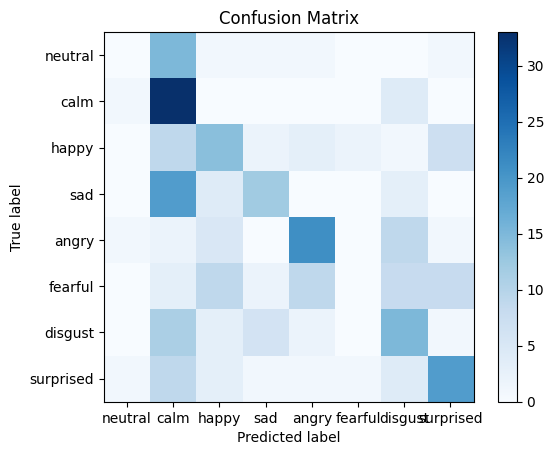

In [100]:
# Plot the confusion matrix
plot_confusion_matrix(all_true, all_preds, class_names)